In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

## define neural net

In [4]:
print('test')
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(3, 20)
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 20)
        self.l6=nn.Linear(20, 20)
        self.l7=nn.Linear(20, 2)
        
    def forward(self, t,x,y):
        txy = torch.cat([t,x,y],axis=1)
        out=torch.tanh(self.l1(txy)) #does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        #out=torch.tanh(self.l4(out))
        #out=torch.tanh(self.l5(out))
        out=torch.tanh(self.l6(out))
        out=self.l7(out)
        return out
k=1
m=1
def f(net,t,x,y):
    psi=net(t,x,y)[:,0]
    p=net(t,x,y)[:,1]
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    ux = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    uy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    vx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    vy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    uxx = torch.autograd.grad(ux.sum(), x, create_graph=True)[0]
    uyy = torch.autograd.grad(uy.sum(), y, create_graph=True)[0]
    vxx = torch.autograd.grad(vx.sum(), x, create_graph=True)[0]
    vyy = torch.autograd.grad(vy.sum(), y, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    px = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    py = torch.autograd.grad(p.sum(), y, create_graph=True)[0]
    f1=ut+u*ux+v*uy+px-0.1*(uxx+uyy)
    f2=vt+u*vx+v*vy+py-0.1*(vxx+vyy)
    mse1=nn.MSELoss()
    pt0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    loss = mse1(f1,pt0)+mse1(f2, pt0)
    return loss

def u_err(net,u_bd,v_bd,y_bd):
    t_bc=np.zeros(1)
    x_bc=np.random.rand(1000)*10.0
    y_bc=np.ones(1)*y_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    #pt_u_bc = Variable(torch.from_numpy(u_bcm).float(), requires_grad=True).to(device)
    #pt_v_bc = Variable(torch.from_numpy(v_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_p(net,p_bd,x_bd):
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    p=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
    mse1=nn.MSELoss()
    p0 = Variable(torch.ones_like(p)*p_bd, requires_grad=False).to(device)
    loss=mse1(p,p0)
    return loss


test
Using cpu device


## train neural net

In [15]:

model = NeuralNetwork().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer=torch.optim.Adam(model.parameters())
for i in range(10000):
    optimizer.zero_grad()
    loss1=u_err(model,0.0,0.0,0.0)+u_err(model,0.0,0.0,1.0)+u_err_p(model,0.0,0.0)+u_err_p(model,1.0,10.0)
    #pred_bc=model(pt_t_bc)
    #loss1=u(model,t0,u0)
    #pt01 = Variable(torch.from_numpy(np.zeros((2,1))).float(), requires_grad=False).to(device)
    
    t=np.zeros((500,1))
    x=np.random.rand(500,1)*10.0
    y=np.random.rand(500,1)*1.0
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_x= Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_y= Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
    loss2=f(model,pt_t, pt_x,pt_y)

    loss = loss2+loss1
    #loss = mse2(loss2,pt02)+mse1(pred_bc, pt01)

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(i)
    print(loss1)
    print(loss2)

0
tensor(1.7503, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1
tensor(1.6632, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
2
tensor(1.5780, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
3
tensor(1.4942, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
4
tensor(1.4120, grad_fn=<AddBackward0>)
tensor(7.8338e-05, grad_fn=<AddBackward0>)
5
tensor(1.3312, grad_fn=<AddBackward0>)
tensor(7.3241e-05, grad_fn=<AddBackward0>)
6
tensor(1.2523, grad_fn=<AddBackward0>)
tensor(9.6943e-05, grad_fn=<AddBackward0>)
7
tensor(1.1751, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
8
tensor(1.1000, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
9
tensor(1.0265, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
10
tensor(0.9558, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
11
tensor(0.8873, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
12
tensor(0.8206, grad_fn=

106
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0199, grad_fn=<AddBackward0>)
107
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0186, grad_fn=<AddBackward0>)
108
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0204, grad_fn=<AddBackward0>)
109
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0193, grad_fn=<AddBackward0>)
110
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0204, grad_fn=<AddBackward0>)
111
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0217, grad_fn=<AddBackward0>)
112
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0207, grad_fn=<AddBackward0>)
113
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0207, grad_fn=<AddBackward0>)
114
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0172, grad_fn=<AddBackward0>)
115
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0181, grad_fn=<AddBackward0>)
116
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0182, grad_fn=<AddBackward0>)
117
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0187, grad_fn=<AddBackward0>)
118
tensor(0.001

209
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0133, grad_fn=<AddBackward0>)
210
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0130, grad_fn=<AddBackward0>)
211
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0137, grad_fn=<AddBackward0>)
212
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0125, grad_fn=<AddBackward0>)
213
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0125, grad_fn=<AddBackward0>)
214
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0120, grad_fn=<AddBackward0>)
215
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0124, grad_fn=<AddBackward0>)
216
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0128, grad_fn=<AddBackward0>)
217
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0131, grad_fn=<AddBackward0>)
218
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0124, grad_fn=<AddBackward0>)
219
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0130, grad_fn=<AddBackward0>)
220
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0118, grad_fn=<AddBackward0>)
221
tensor(0.000

313
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
314
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0111, grad_fn=<AddBackward0>)
315
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0111, grad_fn=<AddBackward0>)
316
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0108, grad_fn=<AddBackward0>)
317
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0108, grad_fn=<AddBackward0>)
318
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0108, grad_fn=<AddBackward0>)
319
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0112, grad_fn=<AddBackward0>)
320
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0109, grad_fn=<AddBackward0>)
321
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)
322
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)
323
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
324
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0110, grad_fn=<AddBackward0>)
325
tensor(0.000

417
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)
418
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0102, grad_fn=<AddBackward0>)
419
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0103, grad_fn=<AddBackward0>)
420
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0103, grad_fn=<AddBackward0>)
421
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
422
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
423
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0106, grad_fn=<AddBackward0>)
424
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0103, grad_fn=<AddBackward0>)
425
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
426
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
427
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)
428
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
429
tensor(0.000

520
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
521
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
522
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0093, grad_fn=<AddBackward0>)
523
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
524
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
525
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
526
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0093, grad_fn=<AddBackward0>)
527
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
528
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
529
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
530
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
531
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
532
tensor(0.000

624
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
625
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
626
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
627
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0083, grad_fn=<AddBackward0>)
628
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0080, grad_fn=<AddBackward0>)
629
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0080, grad_fn=<AddBackward0>)
630
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
631
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
632
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
633
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
634
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
635
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
636
tensor(0.000

728
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
729
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0018, grad_fn=<AddBackward0>)
730
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
731
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
732
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0018, grad_fn=<AddBackward0>)
733
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0016, grad_fn=<AddBackward0>)
734
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
735
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0018, grad_fn=<AddBackward0>)
736
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0016, grad_fn=<AddBackward0>)
737
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0018, grad_fn=<AddBackward0>)
738
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0017, grad_fn=<AddBackward0>)
739
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0016, grad_fn=<AddBackward0>)
740
tensor(0.000

827
tensor(6.0810e-05, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
828
tensor(5.6622e-05, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
829
tensor(5.2419e-05, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
830
tensor(5.4161e-05, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
831
tensor(5.5953e-05, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
832
tensor(6.0795e-05, grad_fn=<AddBackward0>)
tensor(0.0012, grad_fn=<AddBackward0>)
833
tensor(6.7370e-05, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
834
tensor(6.9487e-05, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
835
tensor(6.7389e-05, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
836
tensor(6.0826e-05, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
837
tensor(5.6654e-05, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
838
tensor(5.7917e-05, grad_fn=<AddBackward0>)
tensor(

923
tensor(3.3188e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
924
tensor(3.4425e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
925
tensor(3.4221e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
926
tensor(3.4660e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
927
tensor(3.3100e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
928
tensor(3.1882e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
929
tensor(3.1120e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
930
tensor(3.0877e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
931
tensor(3.1522e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
932
tensor(3.3539e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
933
tensor(3.4426e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
934
tensor(3.4231e-05, grad_fn=<AddBackward0>)
tensor(

1022
tensor(3.2226e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1023
tensor(3.2346e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1024
tensor(3.1788e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1025
tensor(3.1318e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1026
tensor(3.0642e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1027
tensor(3.0240e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1028
tensor(3.1218e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1029
tensor(3.0226e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1030
tensor(2.8858e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1031
tensor(3.0355e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
1032
tensor(3.0554e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1033
tensor(2.9312e-05, grad_fn=<AddBackwar

1120
tensor(3.2608e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1121
tensor(3.2455e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1122
tensor(3.1167e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1123
tensor(3.0315e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1124
tensor(3.0638e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1125
tensor(3.1081e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1126
tensor(3.1657e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1127
tensor(3.3318e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1128
tensor(3.3625e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1129
tensor(3.1367e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1130
tensor(3.0094e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
1131
tensor(2.9595e-05, grad_fn=<AddBackwar

1218
tensor(3.1032e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1219
tensor(2.9081e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1220
tensor(2.7602e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1221
tensor(2.6732e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1222
tensor(2.8700e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1223
tensor(3.0065e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1224
tensor(2.9615e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1225
tensor(2.7152e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1226
tensor(2.6897e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1227
tensor(2.7999e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1228
tensor(2.8289e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1229
tensor(3.0820e-05, grad_fn=<AddBackwar

1315
tensor(2.7555e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1316
tensor(2.5237e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1317
tensor(2.6642e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1318
tensor(3.3741e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1319
tensor(3.8861e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1320
tensor(3.9683e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1321
tensor(3.2547e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1322
tensor(2.5602e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1323
tensor(2.5340e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1324
tensor(3.0088e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1325
tensor(3.2802e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
1326
tensor(2.9400e-05, grad_fn=<AddBackwar

1410
tensor(2.4658e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1411
tensor(2.5118e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1412
tensor(2.7070e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1413
tensor(2.8041e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1414
tensor(2.7743e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1415
tensor(2.6456e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1416
tensor(2.5977e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1417
tensor(2.4912e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1418
tensor(2.4061e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1419
tensor(2.3478e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1420
tensor(2.3831e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1421
tensor(2.3806e-05, grad_fn=<AddBackwar

1506
tensor(2.4619e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1507
tensor(2.5678e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1508
tensor(2.8166e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1509
tensor(2.7976e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1510
tensor(2.7771e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1511
tensor(2.8579e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1512
tensor(3.0207e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1513
tensor(3.5801e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1514
tensor(3.9909e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1515
tensor(4.1498e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1516
tensor(3.8972e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1517
tensor(3.6108e-05, grad_fn=<AddBackwar

1604
tensor(3.0070e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1605
tensor(3.1433e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1606
tensor(3.4539e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1607
tensor(3.6988e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1608
tensor(3.9722e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1609
tensor(4.1713e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
1610
tensor(4.4230e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1611
tensor(4.3283e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1612
tensor(4.2314e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1613
tensor(4.0287e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1614
tensor(3.6747e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1615
tensor(3.2621e-05, grad_fn=<AddBackwar

1699
tensor(2.3497e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1700
tensor(2.5530e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1701
tensor(2.6008e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1702
tensor(2.3849e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1703
tensor(2.0792e-05, grad_fn=<AddBackward0>)
tensor(9.4864e-05, grad_fn=<AddBackward0>)
1704
tensor(2.0561e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1705
tensor(2.1429e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1706
tensor(2.3262e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1707
tensor(2.2466e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1708
tensor(2.1501e-05, grad_fn=<AddBackward0>)
tensor(9.9171e-05, grad_fn=<AddBackward0>)
1709
tensor(2.0565e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1710
tensor(2.0993e-05, grad_fn=<Ad

1797
tensor(2.6876e-05, grad_fn=<AddBackward0>)
tensor(8.2270e-05, grad_fn=<AddBackward0>)
1798
tensor(2.4556e-05, grad_fn=<AddBackward0>)
tensor(8.0203e-05, grad_fn=<AddBackward0>)
1799
tensor(2.2111e-05, grad_fn=<AddBackward0>)
tensor(9.1781e-05, grad_fn=<AddBackward0>)
1800
tensor(1.9985e-05, grad_fn=<AddBackward0>)
tensor(9.3537e-05, grad_fn=<AddBackward0>)
1801
tensor(1.8969e-05, grad_fn=<AddBackward0>)
tensor(8.3486e-05, grad_fn=<AddBackward0>)
1802
tensor(1.9512e-05, grad_fn=<AddBackward0>)
tensor(9.6828e-05, grad_fn=<AddBackward0>)
1803
tensor(2.0297e-05, grad_fn=<AddBackward0>)
tensor(8.1154e-05, grad_fn=<AddBackward0>)
1804
tensor(2.0977e-05, grad_fn=<AddBackward0>)
tensor(9.2064e-05, grad_fn=<AddBackward0>)
1805
tensor(2.1663e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1806
tensor(2.2215e-05, grad_fn=<AddBackward0>)
tensor(9.1568e-05, grad_fn=<AddBackward0>)
1807
tensor(2.0957e-05, grad_fn=<AddBackward0>)
tensor(8.1559e-05, grad_fn=<AddBackward0>)
180

1888
tensor(1.9097e-05, grad_fn=<AddBackward0>)
tensor(8.9354e-05, grad_fn=<AddBackward0>)
1889
tensor(1.8151e-05, grad_fn=<AddBackward0>)
tensor(9.0037e-05, grad_fn=<AddBackward0>)
1890
tensor(1.8502e-05, grad_fn=<AddBackward0>)
tensor(7.0819e-05, grad_fn=<AddBackward0>)
1891
tensor(1.8328e-05, grad_fn=<AddBackward0>)
tensor(6.7088e-05, grad_fn=<AddBackward0>)
1892
tensor(1.8764e-05, grad_fn=<AddBackward0>)
tensor(7.0060e-05, grad_fn=<AddBackward0>)
1893
tensor(1.8347e-05, grad_fn=<AddBackward0>)
tensor(7.6822e-05, grad_fn=<AddBackward0>)
1894
tensor(1.7944e-05, grad_fn=<AddBackward0>)
tensor(7.6714e-05, grad_fn=<AddBackward0>)
1895
tensor(1.8297e-05, grad_fn=<AddBackward0>)
tensor(9.4137e-05, grad_fn=<AddBackward0>)
1896
tensor(1.8040e-05, grad_fn=<AddBackward0>)
tensor(7.8351e-05, grad_fn=<AddBackward0>)
1897
tensor(1.8433e-05, grad_fn=<AddBackward0>)
tensor(7.1723e-05, grad_fn=<AddBackward0>)
1898
tensor(1.8621e-05, grad_fn=<AddBackward0>)
tensor(7.2877e-05, grad_fn=<AddBackward0>)

1979
tensor(1.8725e-05, grad_fn=<AddBackward0>)
tensor(7.0131e-05, grad_fn=<AddBackward0>)
1980
tensor(1.7323e-05, grad_fn=<AddBackward0>)
tensor(5.8022e-05, grad_fn=<AddBackward0>)
1981
tensor(1.6823e-05, grad_fn=<AddBackward0>)
tensor(5.8794e-05, grad_fn=<AddBackward0>)
1982
tensor(1.6692e-05, grad_fn=<AddBackward0>)
tensor(6.5680e-05, grad_fn=<AddBackward0>)
1983
tensor(1.7817e-05, grad_fn=<AddBackward0>)
tensor(5.8148e-05, grad_fn=<AddBackward0>)
1984
tensor(1.8813e-05, grad_fn=<AddBackward0>)
tensor(7.2969e-05, grad_fn=<AddBackward0>)
1985
tensor(2.0559e-05, grad_fn=<AddBackward0>)
tensor(6.5054e-05, grad_fn=<AddBackward0>)
1986
tensor(2.1183e-05, grad_fn=<AddBackward0>)
tensor(6.2793e-05, grad_fn=<AddBackward0>)
1987
tensor(2.2912e-05, grad_fn=<AddBackward0>)
tensor(5.9270e-05, grad_fn=<AddBackward0>)
1988
tensor(2.5895e-05, grad_fn=<AddBackward0>)
tensor(6.9562e-05, grad_fn=<AddBackward0>)
1989
tensor(2.8964e-05, grad_fn=<AddBackward0>)
tensor(6.4944e-05, grad_fn=<AddBackward0>)

2073
tensor(1.7041e-05, grad_fn=<AddBackward0>)
tensor(5.2147e-05, grad_fn=<AddBackward0>)
2074
tensor(1.6448e-05, grad_fn=<AddBackward0>)
tensor(4.9106e-05, grad_fn=<AddBackward0>)
2075
tensor(1.6479e-05, grad_fn=<AddBackward0>)
tensor(6.1004e-05, grad_fn=<AddBackward0>)
2076
tensor(1.7256e-05, grad_fn=<AddBackward0>)
tensor(5.3993e-05, grad_fn=<AddBackward0>)
2077
tensor(1.8479e-05, grad_fn=<AddBackward0>)
tensor(6.1291e-05, grad_fn=<AddBackward0>)
2078
tensor(1.8812e-05, grad_fn=<AddBackward0>)
tensor(5.9206e-05, grad_fn=<AddBackward0>)
2079
tensor(1.9614e-05, grad_fn=<AddBackward0>)
tensor(5.8820e-05, grad_fn=<AddBackward0>)
2080
tensor(1.9229e-05, grad_fn=<AddBackward0>)
tensor(4.8808e-05, grad_fn=<AddBackward0>)
2081
tensor(2.0012e-05, grad_fn=<AddBackward0>)
tensor(5.1766e-05, grad_fn=<AddBackward0>)
2082
tensor(2.0202e-05, grad_fn=<AddBackward0>)
tensor(5.7116e-05, grad_fn=<AddBackward0>)
2083
tensor(2.0999e-05, grad_fn=<AddBackward0>)
tensor(6.0545e-05, grad_fn=<AddBackward0>)

2166
tensor(1.7119e-05, grad_fn=<AddBackward0>)
tensor(5.1674e-05, grad_fn=<AddBackward0>)
2167
tensor(1.7300e-05, grad_fn=<AddBackward0>)
tensor(5.4667e-05, grad_fn=<AddBackward0>)
2168
tensor(1.7628e-05, grad_fn=<AddBackward0>)
tensor(4.9251e-05, grad_fn=<AddBackward0>)
2169
tensor(1.7997e-05, grad_fn=<AddBackward0>)
tensor(4.2472e-05, grad_fn=<AddBackward0>)
2170
tensor(1.8203e-05, grad_fn=<AddBackward0>)
tensor(5.5093e-05, grad_fn=<AddBackward0>)
2171
tensor(1.9081e-05, grad_fn=<AddBackward0>)
tensor(4.3767e-05, grad_fn=<AddBackward0>)
2172
tensor(2.0242e-05, grad_fn=<AddBackward0>)
tensor(5.2861e-05, grad_fn=<AddBackward0>)
2173
tensor(2.0965e-05, grad_fn=<AddBackward0>)
tensor(4.6744e-05, grad_fn=<AddBackward0>)
2174
tensor(2.1904e-05, grad_fn=<AddBackward0>)
tensor(5.4523e-05, grad_fn=<AddBackward0>)
2175
tensor(2.4049e-05, grad_fn=<AddBackward0>)
tensor(3.9239e-05, grad_fn=<AddBackward0>)
2176
tensor(2.6411e-05, grad_fn=<AddBackward0>)
tensor(4.7148e-05, grad_fn=<AddBackward0>)

2257
tensor(1.5609e-05, grad_fn=<AddBackward0>)
tensor(4.6355e-05, grad_fn=<AddBackward0>)
2258
tensor(1.4072e-05, grad_fn=<AddBackward0>)
tensor(4.2821e-05, grad_fn=<AddBackward0>)
2259
tensor(1.3710e-05, grad_fn=<AddBackward0>)
tensor(4.3007e-05, grad_fn=<AddBackward0>)
2260
tensor(1.3725e-05, grad_fn=<AddBackward0>)
tensor(4.1259e-05, grad_fn=<AddBackward0>)
2261
tensor(1.4170e-05, grad_fn=<AddBackward0>)
tensor(3.6965e-05, grad_fn=<AddBackward0>)
2262
tensor(1.4542e-05, grad_fn=<AddBackward0>)
tensor(4.6157e-05, grad_fn=<AddBackward0>)
2263
tensor(1.5452e-05, grad_fn=<AddBackward0>)
tensor(4.0996e-05, grad_fn=<AddBackward0>)
2264
tensor(1.5799e-05, grad_fn=<AddBackward0>)
tensor(4.7794e-05, grad_fn=<AddBackward0>)
2265
tensor(1.5623e-05, grad_fn=<AddBackward0>)
tensor(4.1830e-05, grad_fn=<AddBackward0>)
2266
tensor(1.5627e-05, grad_fn=<AddBackward0>)
tensor(3.9912e-05, grad_fn=<AddBackward0>)
2267
tensor(1.4961e-05, grad_fn=<AddBackward0>)
tensor(5.2854e-05, grad_fn=<AddBackward0>)

2349
tensor(1.3343e-05, grad_fn=<AddBackward0>)
tensor(3.5695e-05, grad_fn=<AddBackward0>)
2350
tensor(1.3463e-05, grad_fn=<AddBackward0>)
tensor(3.8014e-05, grad_fn=<AddBackward0>)
2351
tensor(1.3451e-05, grad_fn=<AddBackward0>)
tensor(3.9995e-05, grad_fn=<AddBackward0>)
2352
tensor(1.3716e-05, grad_fn=<AddBackward0>)
tensor(3.4193e-05, grad_fn=<AddBackward0>)
2353
tensor(1.4088e-05, grad_fn=<AddBackward0>)
tensor(3.5265e-05, grad_fn=<AddBackward0>)
2354
tensor(1.3474e-05, grad_fn=<AddBackward0>)
tensor(4.2349e-05, grad_fn=<AddBackward0>)
2355
tensor(1.2703e-05, grad_fn=<AddBackward0>)
tensor(3.7288e-05, grad_fn=<AddBackward0>)
2356
tensor(1.2586e-05, grad_fn=<AddBackward0>)
tensor(3.7345e-05, grad_fn=<AddBackward0>)
2357
tensor(1.2343e-05, grad_fn=<AddBackward0>)
tensor(3.5710e-05, grad_fn=<AddBackward0>)
2358
tensor(1.2538e-05, grad_fn=<AddBackward0>)
tensor(3.7909e-05, grad_fn=<AddBackward0>)
2359
tensor(1.2662e-05, grad_fn=<AddBackward0>)
tensor(4.1698e-05, grad_fn=<AddBackward0>)

2443
tensor(1.5446e-05, grad_fn=<AddBackward0>)
tensor(4.0413e-05, grad_fn=<AddBackward0>)
2444
tensor(1.6504e-05, grad_fn=<AddBackward0>)
tensor(3.2063e-05, grad_fn=<AddBackward0>)
2445
tensor(1.7764e-05, grad_fn=<AddBackward0>)
tensor(3.4105e-05, grad_fn=<AddBackward0>)
2446
tensor(1.9253e-05, grad_fn=<AddBackward0>)
tensor(3.0499e-05, grad_fn=<AddBackward0>)
2447
tensor(2.1834e-05, grad_fn=<AddBackward0>)
tensor(3.0888e-05, grad_fn=<AddBackward0>)
2448
tensor(2.4002e-05, grad_fn=<AddBackward0>)
tensor(3.6462e-05, grad_fn=<AddBackward0>)
2449
tensor(2.7321e-05, grad_fn=<AddBackward0>)
tensor(3.9087e-05, grad_fn=<AddBackward0>)
2450
tensor(3.2480e-05, grad_fn=<AddBackward0>)
tensor(3.2643e-05, grad_fn=<AddBackward0>)
2451
tensor(3.5532e-05, grad_fn=<AddBackward0>)
tensor(3.2954e-05, grad_fn=<AddBackward0>)
2452
tensor(3.9308e-05, grad_fn=<AddBackward0>)
tensor(3.3948e-05, grad_fn=<AddBackward0>)
2453
tensor(4.1740e-05, grad_fn=<AddBackward0>)
tensor(3.8579e-05, grad_fn=<AddBackward0>)

2534
tensor(1.5105e-05, grad_fn=<AddBackward0>)
tensor(3.4750e-05, grad_fn=<AddBackward0>)
2535
tensor(1.4466e-05, grad_fn=<AddBackward0>)
tensor(3.1436e-05, grad_fn=<AddBackward0>)
2536
tensor(1.3791e-05, grad_fn=<AddBackward0>)
tensor(3.3265e-05, grad_fn=<AddBackward0>)
2537
tensor(1.3512e-05, grad_fn=<AddBackward0>)
tensor(2.8314e-05, grad_fn=<AddBackward0>)
2538
tensor(1.2792e-05, grad_fn=<AddBackward0>)
tensor(2.8921e-05, grad_fn=<AddBackward0>)
2539
tensor(1.2371e-05, grad_fn=<AddBackward0>)
tensor(3.2773e-05, grad_fn=<AddBackward0>)
2540
tensor(1.1908e-05, grad_fn=<AddBackward0>)
tensor(2.8253e-05, grad_fn=<AddBackward0>)
2541
tensor(1.1735e-05, grad_fn=<AddBackward0>)
tensor(2.5586e-05, grad_fn=<AddBackward0>)
2542
tensor(1.0988e-05, grad_fn=<AddBackward0>)
tensor(2.9548e-05, grad_fn=<AddBackward0>)
2543
tensor(1.1059e-05, grad_fn=<AddBackward0>)
tensor(3.1679e-05, grad_fn=<AddBackward0>)
2544
tensor(1.0835e-05, grad_fn=<AddBackward0>)
tensor(2.6208e-05, grad_fn=<AddBackward0>)

2630
tensor(1.0335e-05, grad_fn=<AddBackward0>)
tensor(2.6310e-05, grad_fn=<AddBackward0>)
2631
tensor(1.0432e-05, grad_fn=<AddBackward0>)
tensor(3.0446e-05, grad_fn=<AddBackward0>)
2632
tensor(1.0769e-05, grad_fn=<AddBackward0>)
tensor(2.8078e-05, grad_fn=<AddBackward0>)
2633
tensor(1.0540e-05, grad_fn=<AddBackward0>)
tensor(2.6128e-05, grad_fn=<AddBackward0>)
2634
tensor(1.0227e-05, grad_fn=<AddBackward0>)
tensor(2.4013e-05, grad_fn=<AddBackward0>)
2635
tensor(1.0703e-05, grad_fn=<AddBackward0>)
tensor(3.1060e-05, grad_fn=<AddBackward0>)
2636
tensor(1.0425e-05, grad_fn=<AddBackward0>)
tensor(2.9270e-05, grad_fn=<AddBackward0>)
2637
tensor(1.0738e-05, grad_fn=<AddBackward0>)
tensor(2.6700e-05, grad_fn=<AddBackward0>)
2638
tensor(1.0591e-05, grad_fn=<AddBackward0>)
tensor(2.9648e-05, grad_fn=<AddBackward0>)
2639
tensor(1.0500e-05, grad_fn=<AddBackward0>)
tensor(2.3833e-05, grad_fn=<AddBackward0>)
2640
tensor(1.1034e-05, grad_fn=<AddBackward0>)
tensor(3.1084e-05, grad_fn=<AddBackward0>)

2724
tensor(2.3196e-05, grad_fn=<AddBackward0>)
tensor(2.7719e-05, grad_fn=<AddBackward0>)
2725
tensor(2.5961e-05, grad_fn=<AddBackward0>)
tensor(2.8510e-05, grad_fn=<AddBackward0>)
2726
tensor(2.8411e-05, grad_fn=<AddBackward0>)
tensor(2.3652e-05, grad_fn=<AddBackward0>)
2727
tensor(3.1067e-05, grad_fn=<AddBackward0>)
tensor(2.6594e-05, grad_fn=<AddBackward0>)
2728
tensor(3.4298e-05, grad_fn=<AddBackward0>)
tensor(2.7730e-05, grad_fn=<AddBackward0>)
2729
tensor(3.9859e-05, grad_fn=<AddBackward0>)
tensor(2.8207e-05, grad_fn=<AddBackward0>)
2730
tensor(4.4548e-05, grad_fn=<AddBackward0>)
tensor(2.6357e-05, grad_fn=<AddBackward0>)
2731
tensor(4.8043e-05, grad_fn=<AddBackward0>)
tensor(2.7262e-05, grad_fn=<AddBackward0>)
2732
tensor(4.9901e-05, grad_fn=<AddBackward0>)
tensor(2.0628e-05, grad_fn=<AddBackward0>)
2733
tensor(4.9253e-05, grad_fn=<AddBackward0>)
tensor(2.6513e-05, grad_fn=<AddBackward0>)
2734
tensor(4.5002e-05, grad_fn=<AddBackward0>)
tensor(2.9696e-05, grad_fn=<AddBackward0>)

2820
tensor(8.8043e-06, grad_fn=<AddBackward0>)
tensor(2.4110e-05, grad_fn=<AddBackward0>)
2821
tensor(8.7018e-06, grad_fn=<AddBackward0>)
tensor(2.4264e-05, grad_fn=<AddBackward0>)
2822
tensor(8.8367e-06, grad_fn=<AddBackward0>)
tensor(2.2869e-05, grad_fn=<AddBackward0>)
2823
tensor(8.5714e-06, grad_fn=<AddBackward0>)
tensor(2.4529e-05, grad_fn=<AddBackward0>)
2824
tensor(8.6066e-06, grad_fn=<AddBackward0>)
tensor(2.4062e-05, grad_fn=<AddBackward0>)
2825
tensor(8.7829e-06, grad_fn=<AddBackward0>)
tensor(2.4187e-05, grad_fn=<AddBackward0>)
2826
tensor(8.6971e-06, grad_fn=<AddBackward0>)
tensor(2.1262e-05, grad_fn=<AddBackward0>)
2827
tensor(8.8375e-06, grad_fn=<AddBackward0>)
tensor(2.3289e-05, grad_fn=<AddBackward0>)
2828
tensor(9.1566e-06, grad_fn=<AddBackward0>)
tensor(2.1222e-05, grad_fn=<AddBackward0>)
2829
tensor(9.6082e-06, grad_fn=<AddBackward0>)
tensor(2.2246e-05, grad_fn=<AddBackward0>)
2830
tensor(1.0207e-05, grad_fn=<AddBackward0>)
tensor(2.2918e-05, grad_fn=<AddBackward0>)

2913
tensor(9.6010e-06, grad_fn=<AddBackward0>)
tensor(2.5431e-05, grad_fn=<AddBackward0>)
2914
tensor(8.3400e-06, grad_fn=<AddBackward0>)
tensor(2.4274e-05, grad_fn=<AddBackward0>)
2915
tensor(8.3067e-06, grad_fn=<AddBackward0>)
tensor(2.3203e-05, grad_fn=<AddBackward0>)
2916
tensor(9.0609e-06, grad_fn=<AddBackward0>)
tensor(1.9264e-05, grad_fn=<AddBackward0>)
2917
tensor(1.0482e-05, grad_fn=<AddBackward0>)
tensor(2.1419e-05, grad_fn=<AddBackward0>)
2918
tensor(1.2412e-05, grad_fn=<AddBackward0>)
tensor(2.0587e-05, grad_fn=<AddBackward0>)
2919
tensor(1.3897e-05, grad_fn=<AddBackward0>)
tensor(2.1384e-05, grad_fn=<AddBackward0>)
2920
tensor(1.5228e-05, grad_fn=<AddBackward0>)
tensor(1.7956e-05, grad_fn=<AddBackward0>)
2921
tensor(1.6300e-05, grad_fn=<AddBackward0>)
tensor(1.9480e-05, grad_fn=<AddBackward0>)
2922
tensor(1.7581e-05, grad_fn=<AddBackward0>)
tensor(2.5318e-05, grad_fn=<AddBackward0>)
2923
tensor(1.7898e-05, grad_fn=<AddBackward0>)
tensor(2.0440e-05, grad_fn=<AddBackward0>)

3007
tensor(7.8954e-06, grad_fn=<AddBackward0>)
tensor(2.2009e-05, grad_fn=<AddBackward0>)
3008
tensor(8.2329e-06, grad_fn=<AddBackward0>)
tensor(2.3915e-05, grad_fn=<AddBackward0>)
3009
tensor(8.7748e-06, grad_fn=<AddBackward0>)
tensor(2.1167e-05, grad_fn=<AddBackward0>)
3010
tensor(9.4008e-06, grad_fn=<AddBackward0>)
tensor(2.1765e-05, grad_fn=<AddBackward0>)
3011
tensor(1.0081e-05, grad_fn=<AddBackward0>)
tensor(2.5089e-05, grad_fn=<AddBackward0>)
3012
tensor(1.0064e-05, grad_fn=<AddBackward0>)
tensor(2.0703e-05, grad_fn=<AddBackward0>)
3013
tensor(1.0480e-05, grad_fn=<AddBackward0>)
tensor(2.3463e-05, grad_fn=<AddBackward0>)
3014
tensor(1.1309e-05, grad_fn=<AddBackward0>)
tensor(2.2272e-05, grad_fn=<AddBackward0>)
3015
tensor(1.2176e-05, grad_fn=<AddBackward0>)
tensor(1.8741e-05, grad_fn=<AddBackward0>)
3016
tensor(1.4057e-05, grad_fn=<AddBackward0>)
tensor(2.0558e-05, grad_fn=<AddBackward0>)
3017
tensor(1.6600e-05, grad_fn=<AddBackward0>)
tensor(2.1275e-05, grad_fn=<AddBackward0>)

3101
tensor(8.1671e-06, grad_fn=<AddBackward0>)
tensor(1.8322e-05, grad_fn=<AddBackward0>)
3102
tensor(1.0562e-05, grad_fn=<AddBackward0>)
tensor(1.9111e-05, grad_fn=<AddBackward0>)
3103
tensor(1.2884e-05, grad_fn=<AddBackward0>)
tensor(1.8557e-05, grad_fn=<AddBackward0>)
3104
tensor(1.4274e-05, grad_fn=<AddBackward0>)
tensor(1.9851e-05, grad_fn=<AddBackward0>)
3105
tensor(1.4496e-05, grad_fn=<AddBackward0>)
tensor(2.0295e-05, grad_fn=<AddBackward0>)
3106
tensor(1.3851e-05, grad_fn=<AddBackward0>)
tensor(1.8308e-05, grad_fn=<AddBackward0>)
3107
tensor(1.3012e-05, grad_fn=<AddBackward0>)
tensor(2.0926e-05, grad_fn=<AddBackward0>)
3108
tensor(1.1294e-05, grad_fn=<AddBackward0>)
tensor(2.1688e-05, grad_fn=<AddBackward0>)
3109
tensor(9.9044e-06, grad_fn=<AddBackward0>)
tensor(1.6992e-05, grad_fn=<AddBackward0>)
3110
tensor(8.7149e-06, grad_fn=<AddBackward0>)
tensor(1.9974e-05, grad_fn=<AddBackward0>)
3111
tensor(7.5992e-06, grad_fn=<AddBackward0>)
tensor(2.0662e-05, grad_fn=<AddBackward0>)

3195
tensor(8.8594e-06, grad_fn=<AddBackward0>)
tensor(1.9900e-05, grad_fn=<AddBackward0>)
3196
tensor(8.2946e-06, grad_fn=<AddBackward0>)
tensor(1.8139e-05, grad_fn=<AddBackward0>)
3197
tensor(7.6611e-06, grad_fn=<AddBackward0>)
tensor(1.8571e-05, grad_fn=<AddBackward0>)
3198
tensor(7.3553e-06, grad_fn=<AddBackward0>)
tensor(1.6474e-05, grad_fn=<AddBackward0>)
3199
tensor(7.2553e-06, grad_fn=<AddBackward0>)
tensor(1.8603e-05, grad_fn=<AddBackward0>)
3200
tensor(6.9346e-06, grad_fn=<AddBackward0>)
tensor(1.6728e-05, grad_fn=<AddBackward0>)
3201
tensor(7.0846e-06, grad_fn=<AddBackward0>)
tensor(1.9580e-05, grad_fn=<AddBackward0>)
3202
tensor(6.8433e-06, grad_fn=<AddBackward0>)
tensor(1.6752e-05, grad_fn=<AddBackward0>)
3203
tensor(6.7721e-06, grad_fn=<AddBackward0>)
tensor(1.5594e-05, grad_fn=<AddBackward0>)
3204
tensor(6.7008e-06, grad_fn=<AddBackward0>)
tensor(1.5408e-05, grad_fn=<AddBackward0>)
3205
tensor(6.7036e-06, grad_fn=<AddBackward0>)
tensor(1.7323e-05, grad_fn=<AddBackward0>)

3288
tensor(6.7504e-06, grad_fn=<AddBackward0>)
tensor(1.6135e-05, grad_fn=<AddBackward0>)
3289
tensor(6.2234e-06, grad_fn=<AddBackward0>)
tensor(1.4796e-05, grad_fn=<AddBackward0>)
3290
tensor(6.2861e-06, grad_fn=<AddBackward0>)
tensor(1.6792e-05, grad_fn=<AddBackward0>)
3291
tensor(6.5573e-06, grad_fn=<AddBackward0>)
tensor(1.5568e-05, grad_fn=<AddBackward0>)
3292
tensor(7.0923e-06, grad_fn=<AddBackward0>)
tensor(1.7151e-05, grad_fn=<AddBackward0>)
3293
tensor(7.3926e-06, grad_fn=<AddBackward0>)
tensor(1.5020e-05, grad_fn=<AddBackward0>)
3294
tensor(7.6526e-06, grad_fn=<AddBackward0>)
tensor(1.4740e-05, grad_fn=<AddBackward0>)
3295
tensor(7.5519e-06, grad_fn=<AddBackward0>)
tensor(1.5195e-05, grad_fn=<AddBackward0>)
3296
tensor(7.1125e-06, grad_fn=<AddBackward0>)
tensor(1.5137e-05, grad_fn=<AddBackward0>)
3297
tensor(7.0085e-06, grad_fn=<AddBackward0>)
tensor(1.7293e-05, grad_fn=<AddBackward0>)
3298
tensor(6.7369e-06, grad_fn=<AddBackward0>)
tensor(1.4409e-05, grad_fn=<AddBackward0>)

3384
tensor(8.4428e-06, grad_fn=<AddBackward0>)
tensor(1.3703e-05, grad_fn=<AddBackward0>)
3385
tensor(9.1714e-06, grad_fn=<AddBackward0>)
tensor(1.6676e-05, grad_fn=<AddBackward0>)
3386
tensor(8.8543e-06, grad_fn=<AddBackward0>)
tensor(1.4241e-05, grad_fn=<AddBackward0>)
3387
tensor(7.7387e-06, grad_fn=<AddBackward0>)
tensor(1.2837e-05, grad_fn=<AddBackward0>)
3388
tensor(6.6561e-06, grad_fn=<AddBackward0>)
tensor(1.4292e-05, grad_fn=<AddBackward0>)
3389
tensor(5.9902e-06, grad_fn=<AddBackward0>)
tensor(1.5161e-05, grad_fn=<AddBackward0>)
3390
tensor(5.9041e-06, grad_fn=<AddBackward0>)
tensor(1.6776e-05, grad_fn=<AddBackward0>)
3391
tensor(6.4399e-06, grad_fn=<AddBackward0>)
tensor(1.6196e-05, grad_fn=<AddBackward0>)
3392
tensor(6.9672e-06, grad_fn=<AddBackward0>)
tensor(1.5966e-05, grad_fn=<AddBackward0>)
3393
tensor(7.2024e-06, grad_fn=<AddBackward0>)
tensor(1.4038e-05, grad_fn=<AddBackward0>)
3394
tensor(6.9791e-06, grad_fn=<AddBackward0>)
tensor(1.4834e-05, grad_fn=<AddBackward0>)

3476
tensor(6.7403e-06, grad_fn=<AddBackward0>)
tensor(1.4791e-05, grad_fn=<AddBackward0>)
3477
tensor(7.1805e-06, grad_fn=<AddBackward0>)
tensor(1.5816e-05, grad_fn=<AddBackward0>)
3478
tensor(7.8663e-06, grad_fn=<AddBackward0>)
tensor(1.4309e-05, grad_fn=<AddBackward0>)
3479
tensor(7.8743e-06, grad_fn=<AddBackward0>)
tensor(1.6306e-05, grad_fn=<AddBackward0>)
3480
tensor(8.0659e-06, grad_fn=<AddBackward0>)
tensor(1.5510e-05, grad_fn=<AddBackward0>)
3481
tensor(8.1434e-06, grad_fn=<AddBackward0>)
tensor(1.6605e-05, grad_fn=<AddBackward0>)
3482
tensor(8.3440e-06, grad_fn=<AddBackward0>)
tensor(1.4494e-05, grad_fn=<AddBackward0>)
3483
tensor(9.4209e-06, grad_fn=<AddBackward0>)
tensor(1.3705e-05, grad_fn=<AddBackward0>)
3484
tensor(1.0734e-05, grad_fn=<AddBackward0>)
tensor(1.3530e-05, grad_fn=<AddBackward0>)
3485
tensor(1.2956e-05, grad_fn=<AddBackward0>)
tensor(1.5327e-05, grad_fn=<AddBackward0>)
3486
tensor(1.6344e-05, grad_fn=<AddBackward0>)
tensor(1.5030e-05, grad_fn=<AddBackward0>)

3570
tensor(6.1245e-06, grad_fn=<AddBackward0>)
tensor(1.3658e-05, grad_fn=<AddBackward0>)
3571
tensor(5.8357e-06, grad_fn=<AddBackward0>)
tensor(1.4304e-05, grad_fn=<AddBackward0>)
3572
tensor(5.6705e-06, grad_fn=<AddBackward0>)
tensor(1.4785e-05, grad_fn=<AddBackward0>)
3573
tensor(5.3763e-06, grad_fn=<AddBackward0>)
tensor(1.4812e-05, grad_fn=<AddBackward0>)
3574
tensor(5.5858e-06, grad_fn=<AddBackward0>)
tensor(1.3391e-05, grad_fn=<AddBackward0>)
3575
tensor(5.3847e-06, grad_fn=<AddBackward0>)
tensor(1.2540e-05, grad_fn=<AddBackward0>)
3576
tensor(5.7558e-06, grad_fn=<AddBackward0>)
tensor(1.4107e-05, grad_fn=<AddBackward0>)
3577
tensor(5.6746e-06, grad_fn=<AddBackward0>)
tensor(1.2702e-05, grad_fn=<AddBackward0>)
3578
tensor(5.6552e-06, grad_fn=<AddBackward0>)
tensor(1.3517e-05, grad_fn=<AddBackward0>)
3579
tensor(5.5978e-06, grad_fn=<AddBackward0>)
tensor(1.4434e-05, grad_fn=<AddBackward0>)
3580
tensor(5.4938e-06, grad_fn=<AddBackward0>)
tensor(1.3946e-05, grad_fn=<AddBackward0>)

3663
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.2713e-05, grad_fn=<AddBackward0>)
3664
tensor(7.4494e-05, grad_fn=<AddBackward0>)
tensor(1.3886e-05, grad_fn=<AddBackward0>)
3665
tensor(3.5085e-05, grad_fn=<AddBackward0>)
tensor(1.3254e-05, grad_fn=<AddBackward0>)
3666
tensor(1.0151e-05, grad_fn=<AddBackward0>)
tensor(1.3485e-05, grad_fn=<AddBackward0>)
3667
tensor(6.0687e-06, grad_fn=<AddBackward0>)
tensor(1.3011e-05, grad_fn=<AddBackward0>)
3668
tensor(1.8374e-05, grad_fn=<AddBackward0>)
tensor(1.4230e-05, grad_fn=<AddBackward0>)
3669
tensor(3.4888e-05, grad_fn=<AddBackward0>)
tensor(1.2323e-05, grad_fn=<AddBackward0>)
3670
tensor(4.2936e-05, grad_fn=<AddBackward0>)
tensor(1.2801e-05, grad_fn=<AddBackward0>)
3671
tensor(4.1065e-05, grad_fn=<AddBackward0>)
tensor(1.2940e-05, grad_fn=<AddBackward0>)
3672
tensor(2.8421e-05, grad_fn=<AddBackward0>)
tensor(1.3658e-05, grad_fn=<AddBackward0>)
3673
tensor(1.4272e-05, grad_fn=<AddBackward0>)
tensor(1.2617e-05, grad_fn=<AddBackward0>)
367

3754
tensor(4.6974e-06, grad_fn=<AddBackward0>)
tensor(1.2735e-05, grad_fn=<AddBackward0>)
3755
tensor(4.7125e-06, grad_fn=<AddBackward0>)
tensor(1.2018e-05, grad_fn=<AddBackward0>)
3756
tensor(4.7618e-06, grad_fn=<AddBackward0>)
tensor(1.2136e-05, grad_fn=<AddBackward0>)
3757
tensor(4.8798e-06, grad_fn=<AddBackward0>)
tensor(1.3573e-05, grad_fn=<AddBackward0>)
3758
tensor(5.1209e-06, grad_fn=<AddBackward0>)
tensor(1.1184e-05, grad_fn=<AddBackward0>)
3759
tensor(5.0220e-06, grad_fn=<AddBackward0>)
tensor(1.1812e-05, grad_fn=<AddBackward0>)
3760
tensor(5.2879e-06, grad_fn=<AddBackward0>)
tensor(1.2426e-05, grad_fn=<AddBackward0>)
3761
tensor(5.4659e-06, grad_fn=<AddBackward0>)
tensor(1.2149e-05, grad_fn=<AddBackward0>)
3762
tensor(5.8435e-06, grad_fn=<AddBackward0>)
tensor(1.1958e-05, grad_fn=<AddBackward0>)
3763
tensor(6.1330e-06, grad_fn=<AddBackward0>)
tensor(1.1187e-05, grad_fn=<AddBackward0>)
3764
tensor(6.6011e-06, grad_fn=<AddBackward0>)
tensor(1.2218e-05, grad_fn=<AddBackward0>)

3845
tensor(4.7515e-06, grad_fn=<AddBackward0>)
tensor(1.1586e-05, grad_fn=<AddBackward0>)
3846
tensor(4.7177e-06, grad_fn=<AddBackward0>)
tensor(1.1831e-05, grad_fn=<AddBackward0>)
3847
tensor(4.8008e-06, grad_fn=<AddBackward0>)
tensor(1.0425e-05, grad_fn=<AddBackward0>)
3848
tensor(4.6929e-06, grad_fn=<AddBackward0>)
tensor(1.2815e-05, grad_fn=<AddBackward0>)
3849
tensor(4.5087e-06, grad_fn=<AddBackward0>)
tensor(1.1996e-05, grad_fn=<AddBackward0>)
3850
tensor(4.5896e-06, grad_fn=<AddBackward0>)
tensor(1.1015e-05, grad_fn=<AddBackward0>)
3851
tensor(4.5993e-06, grad_fn=<AddBackward0>)
tensor(1.0477e-05, grad_fn=<AddBackward0>)
3852
tensor(4.2988e-06, grad_fn=<AddBackward0>)
tensor(1.2762e-05, grad_fn=<AddBackward0>)
3853
tensor(4.6739e-06, grad_fn=<AddBackward0>)
tensor(1.1271e-05, grad_fn=<AddBackward0>)
3854
tensor(4.6163e-06, grad_fn=<AddBackward0>)
tensor(9.2846e-06, grad_fn=<AddBackward0>)
3855
tensor(4.6114e-06, grad_fn=<AddBackward0>)
tensor(1.0317e-05, grad_fn=<AddBackward0>)

3937
tensor(6.1624e-06, grad_fn=<AddBackward0>)
tensor(1.1296e-05, grad_fn=<AddBackward0>)
3938
tensor(6.6858e-06, grad_fn=<AddBackward0>)
tensor(1.1361e-05, grad_fn=<AddBackward0>)
3939
tensor(7.3727e-06, grad_fn=<AddBackward0>)
tensor(1.2347e-05, grad_fn=<AddBackward0>)
3940
tensor(7.9415e-06, grad_fn=<AddBackward0>)
tensor(1.0270e-05, grad_fn=<AddBackward0>)
3941
tensor(8.2933e-06, grad_fn=<AddBackward0>)
tensor(1.1330e-05, grad_fn=<AddBackward0>)
3942
tensor(8.8750e-06, grad_fn=<AddBackward0>)
tensor(1.1160e-05, grad_fn=<AddBackward0>)
3943
tensor(9.1165e-06, grad_fn=<AddBackward0>)
tensor(1.2226e-05, grad_fn=<AddBackward0>)
3944
tensor(9.1475e-06, grad_fn=<AddBackward0>)
tensor(1.1147e-05, grad_fn=<AddBackward0>)
3945
tensor(9.2084e-06, grad_fn=<AddBackward0>)
tensor(1.1451e-05, grad_fn=<AddBackward0>)
3946
tensor(9.0093e-06, grad_fn=<AddBackward0>)
tensor(1.1052e-05, grad_fn=<AddBackward0>)
3947
tensor(9.0638e-06, grad_fn=<AddBackward0>)
tensor(1.0601e-05, grad_fn=<AddBackward0>)

4032
tensor(8.4374e-06, grad_fn=<AddBackward0>)
tensor(1.0372e-05, grad_fn=<AddBackward0>)
4033
tensor(8.4292e-06, grad_fn=<AddBackward0>)
tensor(1.0306e-05, grad_fn=<AddBackward0>)
4034
tensor(7.8861e-06, grad_fn=<AddBackward0>)
tensor(1.0407e-05, grad_fn=<AddBackward0>)
4035
tensor(7.3674e-06, grad_fn=<AddBackward0>)
tensor(9.6095e-06, grad_fn=<AddBackward0>)
4036
tensor(6.6040e-06, grad_fn=<AddBackward0>)
tensor(1.0465e-05, grad_fn=<AddBackward0>)
4037
tensor(5.8813e-06, grad_fn=<AddBackward0>)
tensor(9.4387e-06, grad_fn=<AddBackward0>)
4038
tensor(5.2736e-06, grad_fn=<AddBackward0>)
tensor(1.1631e-05, grad_fn=<AddBackward0>)
4039
tensor(4.8489e-06, grad_fn=<AddBackward0>)
tensor(1.1419e-05, grad_fn=<AddBackward0>)
4040
tensor(4.7694e-06, grad_fn=<AddBackward0>)
tensor(9.6710e-06, grad_fn=<AddBackward0>)
4041
tensor(4.3611e-06, grad_fn=<AddBackward0>)
tensor(1.1221e-05, grad_fn=<AddBackward0>)
4042
tensor(4.2254e-06, grad_fn=<AddBackward0>)
tensor(8.7913e-06, grad_fn=<AddBackward0>)

4123
tensor(5.2348e-06, grad_fn=<AddBackward0>)
tensor(9.0832e-06, grad_fn=<AddBackward0>)
4124
tensor(5.4245e-06, grad_fn=<AddBackward0>)
tensor(9.6375e-06, grad_fn=<AddBackward0>)
4125
tensor(5.5499e-06, grad_fn=<AddBackward0>)
tensor(8.5574e-06, grad_fn=<AddBackward0>)
4126
tensor(5.4898e-06, grad_fn=<AddBackward0>)
tensor(9.2477e-06, grad_fn=<AddBackward0>)
4127
tensor(5.5394e-06, grad_fn=<AddBackward0>)
tensor(1.0286e-05, grad_fn=<AddBackward0>)
4128
tensor(5.8121e-06, grad_fn=<AddBackward0>)
tensor(9.3095e-06, grad_fn=<AddBackward0>)
4129
tensor(6.0778e-06, grad_fn=<AddBackward0>)
tensor(1.0035e-05, grad_fn=<AddBackward0>)
4130
tensor(6.6226e-06, grad_fn=<AddBackward0>)
tensor(9.6714e-06, grad_fn=<AddBackward0>)
4131
tensor(7.0208e-06, grad_fn=<AddBackward0>)
tensor(9.4579e-06, grad_fn=<AddBackward0>)
4132
tensor(7.5313e-06, grad_fn=<AddBackward0>)
tensor(1.1444e-05, grad_fn=<AddBackward0>)
4133
tensor(8.6455e-06, grad_fn=<AddBackward0>)
tensor(1.1572e-05, grad_fn=<AddBackward0>)

4220
tensor(5.9565e-06, grad_fn=<AddBackward0>)
tensor(9.7676e-06, grad_fn=<AddBackward0>)
4221
tensor(6.2626e-06, grad_fn=<AddBackward0>)
tensor(9.9361e-06, grad_fn=<AddBackward0>)
4222
tensor(6.1633e-06, grad_fn=<AddBackward0>)
tensor(9.2210e-06, grad_fn=<AddBackward0>)
4223
tensor(5.9348e-06, grad_fn=<AddBackward0>)
tensor(9.7654e-06, grad_fn=<AddBackward0>)
4224
tensor(5.3279e-06, grad_fn=<AddBackward0>)
tensor(9.2847e-06, grad_fn=<AddBackward0>)
4225
tensor(5.4197e-06, grad_fn=<AddBackward0>)
tensor(9.7080e-06, grad_fn=<AddBackward0>)
4226
tensor(5.4671e-06, grad_fn=<AddBackward0>)
tensor(9.0342e-06, grad_fn=<AddBackward0>)
4227
tensor(4.9912e-06, grad_fn=<AddBackward0>)
tensor(8.2158e-06, grad_fn=<AddBackward0>)
4228
tensor(5.4385e-06, grad_fn=<AddBackward0>)
tensor(9.4570e-06, grad_fn=<AddBackward0>)
4229
tensor(5.7197e-06, grad_fn=<AddBackward0>)
tensor(8.8141e-06, grad_fn=<AddBackward0>)
4230
tensor(5.9624e-06, grad_fn=<AddBackward0>)
tensor(8.9797e-06, grad_fn=<AddBackward0>)

4316
tensor(4.3692e-06, grad_fn=<AddBackward0>)
tensor(1.0760e-05, grad_fn=<AddBackward0>)
4317
tensor(4.4751e-06, grad_fn=<AddBackward0>)
tensor(8.0005e-06, grad_fn=<AddBackward0>)
4318
tensor(4.5562e-06, grad_fn=<AddBackward0>)
tensor(9.2209e-06, grad_fn=<AddBackward0>)
4319
tensor(4.5215e-06, grad_fn=<AddBackward0>)
tensor(8.6025e-06, grad_fn=<AddBackward0>)
4320
tensor(4.6023e-06, grad_fn=<AddBackward0>)
tensor(9.2549e-06, grad_fn=<AddBackward0>)
4321
tensor(4.7108e-06, grad_fn=<AddBackward0>)
tensor(1.0020e-05, grad_fn=<AddBackward0>)
4322
tensor(4.7327e-06, grad_fn=<AddBackward0>)
tensor(8.3912e-06, grad_fn=<AddBackward0>)
4323
tensor(4.5375e-06, grad_fn=<AddBackward0>)
tensor(8.7921e-06, grad_fn=<AddBackward0>)
4324
tensor(4.1222e-06, grad_fn=<AddBackward0>)
tensor(8.7648e-06, grad_fn=<AddBackward0>)
4325
tensor(4.2318e-06, grad_fn=<AddBackward0>)
tensor(7.8121e-06, grad_fn=<AddBackward0>)
4326
tensor(3.9709e-06, grad_fn=<AddBackward0>)
tensor(9.6497e-06, grad_fn=<AddBackward0>)

4409
tensor(4.1833e-06, grad_fn=<AddBackward0>)
tensor(8.6328e-06, grad_fn=<AddBackward0>)
4410
tensor(4.0583e-06, grad_fn=<AddBackward0>)
tensor(1.0292e-05, grad_fn=<AddBackward0>)
4411
tensor(4.0514e-06, grad_fn=<AddBackward0>)
tensor(9.1666e-06, grad_fn=<AddBackward0>)
4412
tensor(3.7686e-06, grad_fn=<AddBackward0>)
tensor(8.2269e-06, grad_fn=<AddBackward0>)
4413
tensor(3.4386e-06, grad_fn=<AddBackward0>)
tensor(8.8805e-06, grad_fn=<AddBackward0>)
4414
tensor(3.3066e-06, grad_fn=<AddBackward0>)
tensor(8.6390e-06, grad_fn=<AddBackward0>)
4415
tensor(3.4934e-06, grad_fn=<AddBackward0>)
tensor(9.8068e-06, grad_fn=<AddBackward0>)
4416
tensor(3.6876e-06, grad_fn=<AddBackward0>)
tensor(1.0197e-05, grad_fn=<AddBackward0>)
4417
tensor(3.9988e-06, grad_fn=<AddBackward0>)
tensor(8.1127e-06, grad_fn=<AddBackward0>)
4418
tensor(4.0466e-06, grad_fn=<AddBackward0>)
tensor(8.5585e-06, grad_fn=<AddBackward0>)
4419
tensor(3.9452e-06, grad_fn=<AddBackward0>)
tensor(7.3768e-06, grad_fn=<AddBackward0>)

4502
tensor(8.1380e-06, grad_fn=<AddBackward0>)
tensor(8.2956e-06, grad_fn=<AddBackward0>)
4503
tensor(4.9641e-06, grad_fn=<AddBackward0>)
tensor(8.3089e-06, grad_fn=<AddBackward0>)
4504
tensor(3.5058e-06, grad_fn=<AddBackward0>)
tensor(8.2962e-06, grad_fn=<AddBackward0>)
4505
tensor(3.4854e-06, grad_fn=<AddBackward0>)
tensor(7.7004e-06, grad_fn=<AddBackward0>)
4506
tensor(4.5233e-06, grad_fn=<AddBackward0>)
tensor(9.0202e-06, grad_fn=<AddBackward0>)
4507
tensor(5.7797e-06, grad_fn=<AddBackward0>)
tensor(8.9295e-06, grad_fn=<AddBackward0>)
4508
tensor(6.7199e-06, grad_fn=<AddBackward0>)
tensor(8.9008e-06, grad_fn=<AddBackward0>)
4509
tensor(7.2662e-06, grad_fn=<AddBackward0>)
tensor(9.0906e-06, grad_fn=<AddBackward0>)
4510
tensor(7.2362e-06, grad_fn=<AddBackward0>)
tensor(8.0237e-06, grad_fn=<AddBackward0>)
4511
tensor(6.5709e-06, grad_fn=<AddBackward0>)
tensor(7.4150e-06, grad_fn=<AddBackward0>)
4512
tensor(5.6043e-06, grad_fn=<AddBackward0>)
tensor(8.4650e-06, grad_fn=<AddBackward0>)

4596
tensor(3.0593e-06, grad_fn=<AddBackward0>)
tensor(7.7074e-06, grad_fn=<AddBackward0>)
4597
tensor(4.3510e-06, grad_fn=<AddBackward0>)
tensor(7.0313e-06, grad_fn=<AddBackward0>)
4598
tensor(6.9286e-06, grad_fn=<AddBackward0>)
tensor(8.6666e-06, grad_fn=<AddBackward0>)
4599
tensor(9.0555e-06, grad_fn=<AddBackward0>)
tensor(7.6092e-06, grad_fn=<AddBackward0>)
4600
tensor(1.0116e-05, grad_fn=<AddBackward0>)
tensor(8.0510e-06, grad_fn=<AddBackward0>)
4601
tensor(9.8365e-06, grad_fn=<AddBackward0>)
tensor(7.5668e-06, grad_fn=<AddBackward0>)
4602
tensor(8.1960e-06, grad_fn=<AddBackward0>)
tensor(7.5646e-06, grad_fn=<AddBackward0>)
4603
tensor(6.0913e-06, grad_fn=<AddBackward0>)
tensor(8.2763e-06, grad_fn=<AddBackward0>)
4604
tensor(4.0670e-06, grad_fn=<AddBackward0>)
tensor(7.3922e-06, grad_fn=<AddBackward0>)
4605
tensor(3.2438e-06, grad_fn=<AddBackward0>)
tensor(6.8115e-06, grad_fn=<AddBackward0>)
4606
tensor(3.3722e-06, grad_fn=<AddBackward0>)
tensor(8.6554e-06, grad_fn=<AddBackward0>)

4691
tensor(3.2269e-06, grad_fn=<AddBackward0>)
tensor(7.5628e-06, grad_fn=<AddBackward0>)
4692
tensor(5.9898e-06, grad_fn=<AddBackward0>)
tensor(6.8896e-06, grad_fn=<AddBackward0>)
4693
tensor(1.0645e-05, grad_fn=<AddBackward0>)
tensor(8.6179e-06, grad_fn=<AddBackward0>)
4694
tensor(1.5716e-05, grad_fn=<AddBackward0>)
tensor(6.1993e-06, grad_fn=<AddBackward0>)
4695
tensor(1.8455e-05, grad_fn=<AddBackward0>)
tensor(7.9926e-06, grad_fn=<AddBackward0>)
4696
tensor(1.9400e-05, grad_fn=<AddBackward0>)
tensor(6.8841e-06, grad_fn=<AddBackward0>)
4697
tensor(1.8516e-05, grad_fn=<AddBackward0>)
tensor(6.2376e-06, grad_fn=<AddBackward0>)
4698
tensor(1.6387e-05, grad_fn=<AddBackward0>)
tensor(7.4221e-06, grad_fn=<AddBackward0>)
4699
tensor(1.3099e-05, grad_fn=<AddBackward0>)
tensor(7.3929e-06, grad_fn=<AddBackward0>)
4700
tensor(9.7249e-06, grad_fn=<AddBackward0>)
tensor(7.4986e-06, grad_fn=<AddBackward0>)
4701
tensor(6.6295e-06, grad_fn=<AddBackward0>)
tensor(6.0774e-06, grad_fn=<AddBackward0>)

4787
tensor(8.8193e-06, grad_fn=<AddBackward0>)
tensor(7.8151e-06, grad_fn=<AddBackward0>)
4788
tensor(8.8481e-06, grad_fn=<AddBackward0>)
tensor(6.7836e-06, grad_fn=<AddBackward0>)
4789
tensor(6.8129e-06, grad_fn=<AddBackward0>)
tensor(6.0739e-06, grad_fn=<AddBackward0>)
4790
tensor(4.5461e-06, grad_fn=<AddBackward0>)
tensor(7.3741e-06, grad_fn=<AddBackward0>)
4791
tensor(3.1195e-06, grad_fn=<AddBackward0>)
tensor(8.4387e-06, grad_fn=<AddBackward0>)
4792
tensor(2.9213e-06, grad_fn=<AddBackward0>)
tensor(7.7433e-06, grad_fn=<AddBackward0>)
4793
tensor(3.5930e-06, grad_fn=<AddBackward0>)
tensor(6.4511e-06, grad_fn=<AddBackward0>)
4794
tensor(4.6537e-06, grad_fn=<AddBackward0>)
tensor(7.5185e-06, grad_fn=<AddBackward0>)
4795
tensor(5.5671e-06, grad_fn=<AddBackward0>)
tensor(6.5955e-06, grad_fn=<AddBackward0>)
4796
tensor(5.6480e-06, grad_fn=<AddBackward0>)
tensor(6.6960e-06, grad_fn=<AddBackward0>)
4797
tensor(4.9307e-06, grad_fn=<AddBackward0>)
tensor(6.9742e-06, grad_fn=<AddBackward0>)

4879
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(7.3552e-06, grad_fn=<AddBackward0>)
4880
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.7246e-06, grad_fn=<AddBackward0>)
4881
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.8625e-06, grad_fn=<AddBackward0>)
4882
tensor(9.5074e-05, grad_fn=<AddBackward0>)
tensor(6.2016e-06, grad_fn=<AddBackward0>)
4883
tensor(6.0363e-05, grad_fn=<AddBackward0>)
tensor(7.1423e-06, grad_fn=<AddBackward0>)
4884
tensor(2.8448e-05, grad_fn=<AddBackward0>)
tensor(6.1481e-06, grad_fn=<AddBackward0>)
4885
tensor(7.5329e-06, grad_fn=<AddBackward0>)
tensor(6.7838e-06, grad_fn=<AddBackward0>)
4886
tensor(3.4417e-06, grad_fn=<AddBackward0>)
tensor(6.6467e-06, grad_fn=<AddBackward0>)
4887
tensor(1.4209e-05, grad_fn=<AddBackward0>)
tensor(6.9497e-06, grad_fn=<AddBackward0>)
4888
tensor(2.9145e-05, grad_fn=<AddBackward0>)
tensor(8.0689e-06, grad_fn=<AddBackward0>)
4889
tensor(4.0779e-05, grad_fn=<AddBackward0>)
tensor(6.8500e-06, grad_fn=<AddBackward0>)
4890
tensor

4973
tensor(5.2917e-06, grad_fn=<AddBackward0>)
tensor(6.9967e-06, grad_fn=<AddBackward0>)
4974
tensor(6.1147e-06, grad_fn=<AddBackward0>)
tensor(7.5869e-06, grad_fn=<AddBackward0>)
4975
tensor(7.0131e-06, grad_fn=<AddBackward0>)
tensor(6.6857e-06, grad_fn=<AddBackward0>)
4976
tensor(7.8860e-06, grad_fn=<AddBackward0>)
tensor(6.0624e-06, grad_fn=<AddBackward0>)
4977
tensor(9.1250e-06, grad_fn=<AddBackward0>)
tensor(7.1518e-06, grad_fn=<AddBackward0>)
4978
tensor(1.0652e-05, grad_fn=<AddBackward0>)
tensor(6.5675e-06, grad_fn=<AddBackward0>)
4979
tensor(1.2547e-05, grad_fn=<AddBackward0>)
tensor(7.4428e-06, grad_fn=<AddBackward0>)
4980
tensor(1.4637e-05, grad_fn=<AddBackward0>)
tensor(6.3181e-06, grad_fn=<AddBackward0>)
4981
tensor(1.6959e-05, grad_fn=<AddBackward0>)
tensor(6.9645e-06, grad_fn=<AddBackward0>)
4982
tensor(2.0582e-05, grad_fn=<AddBackward0>)
tensor(6.2228e-06, grad_fn=<AddBackward0>)
4983
tensor(2.4841e-05, grad_fn=<AddBackward0>)
tensor(5.9662e-06, grad_fn=<AddBackward0>)

5064
tensor(2.6494e-06, grad_fn=<AddBackward0>)
tensor(5.8074e-06, grad_fn=<AddBackward0>)
5065
tensor(2.8282e-06, grad_fn=<AddBackward0>)
tensor(6.3360e-06, grad_fn=<AddBackward0>)
5066
tensor(3.0358e-06, grad_fn=<AddBackward0>)
tensor(6.7670e-06, grad_fn=<AddBackward0>)
5067
tensor(3.4283e-06, grad_fn=<AddBackward0>)
tensor(5.5128e-06, grad_fn=<AddBackward0>)
5068
tensor(3.9566e-06, grad_fn=<AddBackward0>)
tensor(6.3071e-06, grad_fn=<AddBackward0>)
5069
tensor(4.8141e-06, grad_fn=<AddBackward0>)
tensor(6.4579e-06, grad_fn=<AddBackward0>)
5070
tensor(6.4494e-06, grad_fn=<AddBackward0>)
tensor(6.7016e-06, grad_fn=<AddBackward0>)
5071
tensor(8.8770e-06, grad_fn=<AddBackward0>)
tensor(5.8672e-06, grad_fn=<AddBackward0>)
5072
tensor(1.2084e-05, grad_fn=<AddBackward0>)
tensor(6.2952e-06, grad_fn=<AddBackward0>)
5073
tensor(1.6462e-05, grad_fn=<AddBackward0>)
tensor(5.8342e-06, grad_fn=<AddBackward0>)
5074
tensor(2.2892e-05, grad_fn=<AddBackward0>)
tensor(6.1290e-06, grad_fn=<AddBackward0>)

5160
tensor(2.6184e-06, grad_fn=<AddBackward0>)
tensor(5.2958e-06, grad_fn=<AddBackward0>)
5161
tensor(2.5032e-06, grad_fn=<AddBackward0>)
tensor(6.7023e-06, grad_fn=<AddBackward0>)
5162
tensor(2.6165e-06, grad_fn=<AddBackward0>)
tensor(6.7901e-06, grad_fn=<AddBackward0>)
5163
tensor(2.5071e-06, grad_fn=<AddBackward0>)
tensor(5.5785e-06, grad_fn=<AddBackward0>)
5164
tensor(2.4516e-06, grad_fn=<AddBackward0>)
tensor(5.9159e-06, grad_fn=<AddBackward0>)
5165
tensor(2.4147e-06, grad_fn=<AddBackward0>)
tensor(6.0781e-06, grad_fn=<AddBackward0>)
5166
tensor(2.4622e-06, grad_fn=<AddBackward0>)
tensor(6.3693e-06, grad_fn=<AddBackward0>)
5167
tensor(2.4559e-06, grad_fn=<AddBackward0>)
tensor(6.4849e-06, grad_fn=<AddBackward0>)
5168
tensor(2.6011e-06, grad_fn=<AddBackward0>)
tensor(6.5950e-06, grad_fn=<AddBackward0>)
5169
tensor(2.4363e-06, grad_fn=<AddBackward0>)
tensor(5.5945e-06, grad_fn=<AddBackward0>)
5170
tensor(2.3890e-06, grad_fn=<AddBackward0>)
tensor(5.9177e-06, grad_fn=<AddBackward0>)

5251
tensor(3.1412e-06, grad_fn=<AddBackward0>)
tensor(6.3521e-06, grad_fn=<AddBackward0>)
5252
tensor(2.4689e-06, grad_fn=<AddBackward0>)
tensor(7.2059e-06, grad_fn=<AddBackward0>)
5253
tensor(2.4177e-06, grad_fn=<AddBackward0>)
tensor(5.2509e-06, grad_fn=<AddBackward0>)
5254
tensor(2.5565e-06, grad_fn=<AddBackward0>)
tensor(4.8770e-06, grad_fn=<AddBackward0>)
5255
tensor(3.2374e-06, grad_fn=<AddBackward0>)
tensor(5.6484e-06, grad_fn=<AddBackward0>)
5256
tensor(4.1769e-06, grad_fn=<AddBackward0>)
tensor(6.0671e-06, grad_fn=<AddBackward0>)
5257
tensor(4.9075e-06, grad_fn=<AddBackward0>)
tensor(5.5219e-06, grad_fn=<AddBackward0>)
5258
tensor(5.3774e-06, grad_fn=<AddBackward0>)
tensor(6.0332e-06, grad_fn=<AddBackward0>)
5259
tensor(6.0234e-06, grad_fn=<AddBackward0>)
tensor(5.6601e-06, grad_fn=<AddBackward0>)
5260
tensor(6.3756e-06, grad_fn=<AddBackward0>)
tensor(5.5582e-06, grad_fn=<AddBackward0>)
5261
tensor(6.5692e-06, grad_fn=<AddBackward0>)
tensor(4.9759e-06, grad_fn=<AddBackward0>)

5348
tensor(1.8166e-05, grad_fn=<AddBackward0>)
tensor(5.9203e-06, grad_fn=<AddBackward0>)
5349
tensor(1.3356e-05, grad_fn=<AddBackward0>)
tensor(4.9599e-06, grad_fn=<AddBackward0>)
5350
tensor(8.8960e-06, grad_fn=<AddBackward0>)
tensor(4.8797e-06, grad_fn=<AddBackward0>)
5351
tensor(5.6918e-06, grad_fn=<AddBackward0>)
tensor(5.4400e-06, grad_fn=<AddBackward0>)
5352
tensor(3.3603e-06, grad_fn=<AddBackward0>)
tensor(5.7830e-06, grad_fn=<AddBackward0>)
5353
tensor(2.4939e-06, grad_fn=<AddBackward0>)
tensor(5.8154e-06, grad_fn=<AddBackward0>)
5354
tensor(2.7553e-06, grad_fn=<AddBackward0>)
tensor(6.0195e-06, grad_fn=<AddBackward0>)
5355
tensor(4.0660e-06, grad_fn=<AddBackward0>)
tensor(4.9420e-06, grad_fn=<AddBackward0>)
5356
tensor(6.2811e-06, grad_fn=<AddBackward0>)
tensor(5.9687e-06, grad_fn=<AddBackward0>)
5357
tensor(8.7704e-06, grad_fn=<AddBackward0>)
tensor(5.7195e-06, grad_fn=<AddBackward0>)
5358
tensor(1.1577e-05, grad_fn=<AddBackward0>)
tensor(4.9850e-06, grad_fn=<AddBackward0>)

5444
tensor(6.0539e-06, grad_fn=<AddBackward0>)
tensor(6.2845e-06, grad_fn=<AddBackward0>)
5445
tensor(7.2696e-06, grad_fn=<AddBackward0>)
tensor(5.4977e-06, grad_fn=<AddBackward0>)
5446
tensor(8.0728e-06, grad_fn=<AddBackward0>)
tensor(6.2786e-06, grad_fn=<AddBackward0>)
5447
tensor(8.1712e-06, grad_fn=<AddBackward0>)
tensor(6.0610e-06, grad_fn=<AddBackward0>)
5448
tensor(7.9553e-06, grad_fn=<AddBackward0>)
tensor(5.8669e-06, grad_fn=<AddBackward0>)
5449
tensor(7.2849e-06, grad_fn=<AddBackward0>)
tensor(5.1483e-06, grad_fn=<AddBackward0>)
5450
tensor(6.5266e-06, grad_fn=<AddBackward0>)
tensor(5.9157e-06, grad_fn=<AddBackward0>)
5451
tensor(5.5042e-06, grad_fn=<AddBackward0>)
tensor(5.0402e-06, grad_fn=<AddBackward0>)
5452
tensor(4.8774e-06, grad_fn=<AddBackward0>)
tensor(5.8658e-06, grad_fn=<AddBackward0>)
5453
tensor(4.0159e-06, grad_fn=<AddBackward0>)
tensor(5.6561e-06, grad_fn=<AddBackward0>)
5454
tensor(3.4220e-06, grad_fn=<AddBackward0>)
tensor(5.8312e-06, grad_fn=<AddBackward0>)

5538
tensor(3.0143e-06, grad_fn=<AddBackward0>)
tensor(5.1615e-06, grad_fn=<AddBackward0>)
5539
tensor(2.3529e-06, grad_fn=<AddBackward0>)
tensor(5.2388e-06, grad_fn=<AddBackward0>)
5540
tensor(2.1554e-06, grad_fn=<AddBackward0>)
tensor(4.5581e-06, grad_fn=<AddBackward0>)
5541
tensor(2.2930e-06, grad_fn=<AddBackward0>)
tensor(4.7605e-06, grad_fn=<AddBackward0>)
5542
tensor(2.6500e-06, grad_fn=<AddBackward0>)
tensor(5.0867e-06, grad_fn=<AddBackward0>)
5543
tensor(3.1342e-06, grad_fn=<AddBackward0>)
tensor(4.8690e-06, grad_fn=<AddBackward0>)
5544
tensor(3.3889e-06, grad_fn=<AddBackward0>)
tensor(5.0251e-06, grad_fn=<AddBackward0>)
5545
tensor(3.4429e-06, grad_fn=<AddBackward0>)
tensor(4.8285e-06, grad_fn=<AddBackward0>)
5546
tensor(3.3403e-06, grad_fn=<AddBackward0>)
tensor(5.3873e-06, grad_fn=<AddBackward0>)
5547
tensor(3.2031e-06, grad_fn=<AddBackward0>)
tensor(4.8951e-06, grad_fn=<AddBackward0>)
5548
tensor(2.9199e-06, grad_fn=<AddBackward0>)
tensor(5.6409e-06, grad_fn=<AddBackward0>)

5633
tensor(3.6116e-06, grad_fn=<AddBackward0>)
tensor(4.4346e-06, grad_fn=<AddBackward0>)
5634
tensor(3.4741e-06, grad_fn=<AddBackward0>)
tensor(4.4278e-06, grad_fn=<AddBackward0>)
5635
tensor(3.1455e-06, grad_fn=<AddBackward0>)
tensor(5.4940e-06, grad_fn=<AddBackward0>)
5636
tensor(3.1174e-06, grad_fn=<AddBackward0>)
tensor(4.3870e-06, grad_fn=<AddBackward0>)
5637
tensor(2.9719e-06, grad_fn=<AddBackward0>)
tensor(5.5800e-06, grad_fn=<AddBackward0>)
5638
tensor(3.2883e-06, grad_fn=<AddBackward0>)
tensor(4.4778e-06, grad_fn=<AddBackward0>)
5639
tensor(3.5547e-06, grad_fn=<AddBackward0>)
tensor(4.7688e-06, grad_fn=<AddBackward0>)
5640
tensor(3.6304e-06, grad_fn=<AddBackward0>)
tensor(4.8798e-06, grad_fn=<AddBackward0>)
5641
tensor(3.8188e-06, grad_fn=<AddBackward0>)
tensor(5.3861e-06, grad_fn=<AddBackward0>)
5642
tensor(3.6513e-06, grad_fn=<AddBackward0>)
tensor(5.1214e-06, grad_fn=<AddBackward0>)
5643
tensor(3.4747e-06, grad_fn=<AddBackward0>)
tensor(5.5497e-06, grad_fn=<AddBackward0>)

5729
tensor(5.1554e-06, grad_fn=<AddBackward0>)
tensor(4.6867e-06, grad_fn=<AddBackward0>)
5730
tensor(3.0658e-06, grad_fn=<AddBackward0>)
tensor(5.0967e-06, grad_fn=<AddBackward0>)
5731
tensor(2.2939e-06, grad_fn=<AddBackward0>)
tensor(5.5664e-06, grad_fn=<AddBackward0>)
5732
tensor(2.8053e-06, grad_fn=<AddBackward0>)
tensor(4.9802e-06, grad_fn=<AddBackward0>)
5733
tensor(4.0127e-06, grad_fn=<AddBackward0>)
tensor(5.1826e-06, grad_fn=<AddBackward0>)
5734
tensor(4.8969e-06, grad_fn=<AddBackward0>)
tensor(5.1327e-06, grad_fn=<AddBackward0>)
5735
tensor(4.5589e-06, grad_fn=<AddBackward0>)
tensor(5.1091e-06, grad_fn=<AddBackward0>)
5736
tensor(3.6279e-06, grad_fn=<AddBackward0>)
tensor(5.1161e-06, grad_fn=<AddBackward0>)
5737
tensor(2.4029e-06, grad_fn=<AddBackward0>)
tensor(5.1527e-06, grad_fn=<AddBackward0>)
5738
tensor(2.0684e-06, grad_fn=<AddBackward0>)
tensor(5.0384e-06, grad_fn=<AddBackward0>)
5739
tensor(2.4335e-06, grad_fn=<AddBackward0>)
tensor(4.7686e-06, grad_fn=<AddBackward0>)

5821
tensor(3.2699e-06, grad_fn=<AddBackward0>)
tensor(4.9542e-06, grad_fn=<AddBackward0>)
5822
tensor(3.4101e-06, grad_fn=<AddBackward0>)
tensor(4.4604e-06, grad_fn=<AddBackward0>)
5823
tensor(3.7405e-06, grad_fn=<AddBackward0>)
tensor(4.5143e-06, grad_fn=<AddBackward0>)
5824
tensor(4.0830e-06, grad_fn=<AddBackward0>)
tensor(4.8947e-06, grad_fn=<AddBackward0>)
5825
tensor(4.7498e-06, grad_fn=<AddBackward0>)
tensor(5.2180e-06, grad_fn=<AddBackward0>)
5826
tensor(5.7966e-06, grad_fn=<AddBackward0>)
tensor(5.1633e-06, grad_fn=<AddBackward0>)
5827
tensor(7.4225e-06, grad_fn=<AddBackward0>)
tensor(4.5585e-06, grad_fn=<AddBackward0>)
5828
tensor(9.3384e-06, grad_fn=<AddBackward0>)
tensor(4.7567e-06, grad_fn=<AddBackward0>)
5829
tensor(1.2163e-05, grad_fn=<AddBackward0>)
tensor(4.2927e-06, grad_fn=<AddBackward0>)
5830
tensor(1.6666e-05, grad_fn=<AddBackward0>)
tensor(5.0946e-06, grad_fn=<AddBackward0>)
5831
tensor(2.2861e-05, grad_fn=<AddBackward0>)
tensor(3.9417e-06, grad_fn=<AddBackward0>)

5914
tensor(1.7640e-05, grad_fn=<AddBackward0>)
tensor(4.7263e-06, grad_fn=<AddBackward0>)
5915
tensor(2.2179e-05, grad_fn=<AddBackward0>)
tensor(4.5008e-06, grad_fn=<AddBackward0>)
5916
tensor(2.6871e-05, grad_fn=<AddBackward0>)
tensor(4.9700e-06, grad_fn=<AddBackward0>)
5917
tensor(3.1272e-05, grad_fn=<AddBackward0>)
tensor(4.7427e-06, grad_fn=<AddBackward0>)
5918
tensor(3.3904e-05, grad_fn=<AddBackward0>)
tensor(4.5798e-06, grad_fn=<AddBackward0>)
5919
tensor(3.4044e-05, grad_fn=<AddBackward0>)
tensor(4.4211e-06, grad_fn=<AddBackward0>)
5920
tensor(3.1008e-05, grad_fn=<AddBackward0>)
tensor(5.4834e-06, grad_fn=<AddBackward0>)
5921
tensor(2.6106e-05, grad_fn=<AddBackward0>)
tensor(4.1005e-06, grad_fn=<AddBackward0>)
5922
tensor(2.0724e-05, grad_fn=<AddBackward0>)
tensor(5.0354e-06, grad_fn=<AddBackward0>)
5923
tensor(1.7005e-05, grad_fn=<AddBackward0>)
tensor(4.6833e-06, grad_fn=<AddBackward0>)
5924
tensor(1.5185e-05, grad_fn=<AddBackward0>)
tensor(5.0708e-06, grad_fn=<AddBackward0>)

6011
tensor(2.4770e-06, grad_fn=<AddBackward0>)
tensor(4.6337e-06, grad_fn=<AddBackward0>)
6012
tensor(2.7580e-06, grad_fn=<AddBackward0>)
tensor(4.0656e-06, grad_fn=<AddBackward0>)
6013
tensor(3.0649e-06, grad_fn=<AddBackward0>)
tensor(4.8777e-06, grad_fn=<AddBackward0>)
6014
tensor(3.1457e-06, grad_fn=<AddBackward0>)
tensor(4.8552e-06, grad_fn=<AddBackward0>)
6015
tensor(3.3901e-06, grad_fn=<AddBackward0>)
tensor(4.6803e-06, grad_fn=<AddBackward0>)
6016
tensor(3.3165e-06, grad_fn=<AddBackward0>)
tensor(5.1784e-06, grad_fn=<AddBackward0>)
6017
tensor(3.2783e-06, grad_fn=<AddBackward0>)
tensor(4.3858e-06, grad_fn=<AddBackward0>)
6018
tensor(3.2424e-06, grad_fn=<AddBackward0>)
tensor(4.3731e-06, grad_fn=<AddBackward0>)
6019
tensor(3.1338e-06, grad_fn=<AddBackward0>)
tensor(4.2985e-06, grad_fn=<AddBackward0>)
6020
tensor(3.0697e-06, grad_fn=<AddBackward0>)
tensor(3.9996e-06, grad_fn=<AddBackward0>)
6021
tensor(2.9218e-06, grad_fn=<AddBackward0>)
tensor(4.5709e-06, grad_fn=<AddBackward0>)

6103
tensor(4.7514e-06, grad_fn=<AddBackward0>)
tensor(4.8111e-06, grad_fn=<AddBackward0>)
6104
tensor(3.2408e-06, grad_fn=<AddBackward0>)
tensor(4.1015e-06, grad_fn=<AddBackward0>)
6105
tensor(2.0897e-06, grad_fn=<AddBackward0>)
tensor(4.4294e-06, grad_fn=<AddBackward0>)
6106
tensor(2.4588e-06, grad_fn=<AddBackward0>)
tensor(4.4554e-06, grad_fn=<AddBackward0>)
6107
tensor(3.6336e-06, grad_fn=<AddBackward0>)
tensor(5.0613e-06, grad_fn=<AddBackward0>)
6108
tensor(4.5111e-06, grad_fn=<AddBackward0>)
tensor(4.6833e-06, grad_fn=<AddBackward0>)
6109
tensor(4.1421e-06, grad_fn=<AddBackward0>)
tensor(4.7219e-06, grad_fn=<AddBackward0>)
6110
tensor(3.1316e-06, grad_fn=<AddBackward0>)
tensor(3.7161e-06, grad_fn=<AddBackward0>)
6111
tensor(2.1702e-06, grad_fn=<AddBackward0>)
tensor(4.4269e-06, grad_fn=<AddBackward0>)
6112
tensor(1.9709e-06, grad_fn=<AddBackward0>)
tensor(4.2194e-06, grad_fn=<AddBackward0>)
6113
tensor(2.6069e-06, grad_fn=<AddBackward0>)
tensor(4.9497e-06, grad_fn=<AddBackward0>)

6199
tensor(7.9907e-06, grad_fn=<AddBackward0>)
tensor(4.4014e-06, grad_fn=<AddBackward0>)
6200
tensor(8.0239e-06, grad_fn=<AddBackward0>)
tensor(4.8514e-06, grad_fn=<AddBackward0>)
6201
tensor(7.8091e-06, grad_fn=<AddBackward0>)
tensor(3.9113e-06, grad_fn=<AddBackward0>)
6202
tensor(7.1509e-06, grad_fn=<AddBackward0>)
tensor(4.3457e-06, grad_fn=<AddBackward0>)
6203
tensor(6.0948e-06, grad_fn=<AddBackward0>)
tensor(3.9553e-06, grad_fn=<AddBackward0>)
6204
tensor(5.1222e-06, grad_fn=<AddBackward0>)
tensor(4.3340e-06, grad_fn=<AddBackward0>)
6205
tensor(4.0828e-06, grad_fn=<AddBackward0>)
tensor(3.8933e-06, grad_fn=<AddBackward0>)
6206
tensor(3.0354e-06, grad_fn=<AddBackward0>)
tensor(4.8708e-06, grad_fn=<AddBackward0>)
6207
tensor(2.4732e-06, grad_fn=<AddBackward0>)
tensor(5.2295e-06, grad_fn=<AddBackward0>)
6208
tensor(2.0541e-06, grad_fn=<AddBackward0>)
tensor(3.7245e-06, grad_fn=<AddBackward0>)
6209
tensor(1.8096e-06, grad_fn=<AddBackward0>)
tensor(4.1332e-06, grad_fn=<AddBackward0>)

6295
tensor(3.3297e-06, grad_fn=<AddBackward0>)
tensor(4.2681e-06, grad_fn=<AddBackward0>)
6296
tensor(2.4407e-06, grad_fn=<AddBackward0>)
tensor(4.6137e-06, grad_fn=<AddBackward0>)
6297
tensor(1.8459e-06, grad_fn=<AddBackward0>)
tensor(4.0407e-06, grad_fn=<AddBackward0>)
6298
tensor(1.8423e-06, grad_fn=<AddBackward0>)
tensor(4.3728e-06, grad_fn=<AddBackward0>)
6299
tensor(2.3513e-06, grad_fn=<AddBackward0>)
tensor(4.3026e-06, grad_fn=<AddBackward0>)
6300
tensor(2.7251e-06, grad_fn=<AddBackward0>)
tensor(4.7949e-06, grad_fn=<AddBackward0>)
6301
tensor(3.0891e-06, grad_fn=<AddBackward0>)
tensor(4.6877e-06, grad_fn=<AddBackward0>)
6302
tensor(3.1240e-06, grad_fn=<AddBackward0>)
tensor(3.2991e-06, grad_fn=<AddBackward0>)
6303
tensor(2.8304e-06, grad_fn=<AddBackward0>)
tensor(4.0437e-06, grad_fn=<AddBackward0>)
6304
tensor(2.2873e-06, grad_fn=<AddBackward0>)
tensor(3.9634e-06, grad_fn=<AddBackward0>)
6305
tensor(2.0483e-06, grad_fn=<AddBackward0>)
tensor(4.9284e-06, grad_fn=<AddBackward0>)

6386
tensor(7.5948e-05, grad_fn=<AddBackward0>)
tensor(4.7001e-06, grad_fn=<AddBackward0>)
6387
tensor(6.3491e-05, grad_fn=<AddBackward0>)
tensor(4.4632e-06, grad_fn=<AddBackward0>)
6388
tensor(4.4792e-05, grad_fn=<AddBackward0>)
tensor(4.8187e-06, grad_fn=<AddBackward0>)
6389
tensor(2.5474e-05, grad_fn=<AddBackward0>)
tensor(4.5144e-06, grad_fn=<AddBackward0>)
6390
tensor(9.6950e-06, grad_fn=<AddBackward0>)
tensor(4.5443e-06, grad_fn=<AddBackward0>)
6391
tensor(2.3351e-06, grad_fn=<AddBackward0>)
tensor(4.2172e-06, grad_fn=<AddBackward0>)
6392
tensor(3.0373e-06, grad_fn=<AddBackward0>)
tensor(3.5258e-06, grad_fn=<AddBackward0>)
6393
tensor(9.3716e-06, grad_fn=<AddBackward0>)
tensor(4.3757e-06, grad_fn=<AddBackward0>)
6394
tensor(1.7304e-05, grad_fn=<AddBackward0>)
tensor(4.0447e-06, grad_fn=<AddBackward0>)
6395
tensor(2.2116e-05, grad_fn=<AddBackward0>)
tensor(4.5109e-06, grad_fn=<AddBackward0>)
6396
tensor(2.2480e-05, grad_fn=<AddBackward0>)
tensor(4.5624e-06, grad_fn=<AddBackward0>)

6477
tensor(1.0802e-05, grad_fn=<AddBackward0>)
tensor(4.0674e-06, grad_fn=<AddBackward0>)
6478
tensor(7.2237e-06, grad_fn=<AddBackward0>)
tensor(3.6694e-06, grad_fn=<AddBackward0>)
6479
tensor(4.1117e-06, grad_fn=<AddBackward0>)
tensor(3.9125e-06, grad_fn=<AddBackward0>)
6480
tensor(3.1988e-06, grad_fn=<AddBackward0>)
tensor(4.4486e-06, grad_fn=<AddBackward0>)
6481
tensor(4.0368e-06, grad_fn=<AddBackward0>)
tensor(4.0077e-06, grad_fn=<AddBackward0>)
6482
tensor(5.7772e-06, grad_fn=<AddBackward0>)
tensor(3.9571e-06, grad_fn=<AddBackward0>)
6483
tensor(6.7275e-06, grad_fn=<AddBackward0>)
tensor(4.9056e-06, grad_fn=<AddBackward0>)
6484
tensor(6.5823e-06, grad_fn=<AddBackward0>)
tensor(4.3649e-06, grad_fn=<AddBackward0>)
6485
tensor(5.1458e-06, grad_fn=<AddBackward0>)
tensor(3.8325e-06, grad_fn=<AddBackward0>)
6486
tensor(3.5628e-06, grad_fn=<AddBackward0>)
tensor(3.8146e-06, grad_fn=<AddBackward0>)
6487
tensor(2.8363e-06, grad_fn=<AddBackward0>)
tensor(4.1575e-06, grad_fn=<AddBackward0>)

6568
tensor(2.4466e-06, grad_fn=<AddBackward0>)
tensor(3.7528e-06, grad_fn=<AddBackward0>)
6569
tensor(2.2427e-06, grad_fn=<AddBackward0>)
tensor(3.8634e-06, grad_fn=<AddBackward0>)
6570
tensor(2.1023e-06, grad_fn=<AddBackward0>)
tensor(4.2469e-06, grad_fn=<AddBackward0>)
6571
tensor(1.9548e-06, grad_fn=<AddBackward0>)
tensor(3.8237e-06, grad_fn=<AddBackward0>)
6572
tensor(2.0249e-06, grad_fn=<AddBackward0>)
tensor(3.1601e-06, grad_fn=<AddBackward0>)
6573
tensor(1.9541e-06, grad_fn=<AddBackward0>)
tensor(4.1912e-06, grad_fn=<AddBackward0>)
6574
tensor(2.1000e-06, grad_fn=<AddBackward0>)
tensor(3.8079e-06, grad_fn=<AddBackward0>)
6575
tensor(2.0559e-06, grad_fn=<AddBackward0>)
tensor(3.5723e-06, grad_fn=<AddBackward0>)
6576
tensor(2.1103e-06, grad_fn=<AddBackward0>)
tensor(3.8211e-06, grad_fn=<AddBackward0>)
6577
tensor(1.9347e-06, grad_fn=<AddBackward0>)
tensor(4.0257e-06, grad_fn=<AddBackward0>)
6578
tensor(1.9472e-06, grad_fn=<AddBackward0>)
tensor(4.3125e-06, grad_fn=<AddBackward0>)

6659
tensor(4.5863e-06, grad_fn=<AddBackward0>)
tensor(3.8213e-06, grad_fn=<AddBackward0>)
6660
tensor(2.9293e-06, grad_fn=<AddBackward0>)
tensor(3.4778e-06, grad_fn=<AddBackward0>)
6661
tensor(2.3123e-06, grad_fn=<AddBackward0>)
tensor(4.3100e-06, grad_fn=<AddBackward0>)
6662
tensor(2.9889e-06, grad_fn=<AddBackward0>)
tensor(3.3720e-06, grad_fn=<AddBackward0>)
6663
tensor(4.2731e-06, grad_fn=<AddBackward0>)
tensor(4.2948e-06, grad_fn=<AddBackward0>)
6664
tensor(5.4516e-06, grad_fn=<AddBackward0>)
tensor(4.2532e-06, grad_fn=<AddBackward0>)
6665
tensor(5.4464e-06, grad_fn=<AddBackward0>)
tensor(4.4364e-06, grad_fn=<AddBackward0>)
6666
tensor(4.4616e-06, grad_fn=<AddBackward0>)
tensor(4.0645e-06, grad_fn=<AddBackward0>)
6667
tensor(3.0512e-06, grad_fn=<AddBackward0>)
tensor(3.6178e-06, grad_fn=<AddBackward0>)
6668
tensor(1.9994e-06, grad_fn=<AddBackward0>)
tensor(3.7220e-06, grad_fn=<AddBackward0>)
6669
tensor(1.8222e-06, grad_fn=<AddBackward0>)
tensor(4.5191e-06, grad_fn=<AddBackward0>)

6751
tensor(2.9389e-06, grad_fn=<AddBackward0>)
tensor(3.8943e-06, grad_fn=<AddBackward0>)
6752
tensor(3.4153e-06, grad_fn=<AddBackward0>)
tensor(3.8398e-06, grad_fn=<AddBackward0>)
6753
tensor(9.3429e-06, grad_fn=<AddBackward0>)
tensor(3.6919e-06, grad_fn=<AddBackward0>)
6754
tensor(1.5664e-05, grad_fn=<AddBackward0>)
tensor(3.7545e-06, grad_fn=<AddBackward0>)
6755
tensor(1.7535e-05, grad_fn=<AddBackward0>)
tensor(3.5634e-06, grad_fn=<AddBackward0>)
6756
tensor(1.4238e-05, grad_fn=<AddBackward0>)
tensor(3.4647e-06, grad_fn=<AddBackward0>)
6757
tensor(8.6377e-06, grad_fn=<AddBackward0>)
tensor(3.8619e-06, grad_fn=<AddBackward0>)
6758
tensor(3.6581e-06, grad_fn=<AddBackward0>)
tensor(4.1734e-06, grad_fn=<AddBackward0>)
6759
tensor(1.8777e-06, grad_fn=<AddBackward0>)
tensor(4.0516e-06, grad_fn=<AddBackward0>)
6760
tensor(2.9737e-06, grad_fn=<AddBackward0>)
tensor(3.7966e-06, grad_fn=<AddBackward0>)
6761
tensor(5.6691e-06, grad_fn=<AddBackward0>)
tensor(3.6864e-06, grad_fn=<AddBackward0>)

6848
tensor(3.0530e-06, grad_fn=<AddBackward0>)
tensor(4.1453e-06, grad_fn=<AddBackward0>)
6849
tensor(4.9989e-06, grad_fn=<AddBackward0>)
tensor(3.8907e-06, grad_fn=<AddBackward0>)
6850
tensor(1.0132e-05, grad_fn=<AddBackward0>)
tensor(3.6270e-06, grad_fn=<AddBackward0>)
6851
tensor(1.4934e-05, grad_fn=<AddBackward0>)
tensor(3.5738e-06, grad_fn=<AddBackward0>)
6852
tensor(1.7577e-05, grad_fn=<AddBackward0>)
tensor(3.7027e-06, grad_fn=<AddBackward0>)
6853
tensor(1.6671e-05, grad_fn=<AddBackward0>)
tensor(3.7071e-06, grad_fn=<AddBackward0>)
6854
tensor(1.3658e-05, grad_fn=<AddBackward0>)
tensor(3.9420e-06, grad_fn=<AddBackward0>)
6855
tensor(1.0144e-05, grad_fn=<AddBackward0>)
tensor(3.7347e-06, grad_fn=<AddBackward0>)
6856
tensor(7.5434e-06, grad_fn=<AddBackward0>)
tensor(3.4768e-06, grad_fn=<AddBackward0>)
6857
tensor(6.1323e-06, grad_fn=<AddBackward0>)
tensor(4.1772e-06, grad_fn=<AddBackward0>)
6858
tensor(5.9483e-06, grad_fn=<AddBackward0>)
tensor(3.5293e-06, grad_fn=<AddBackward0>)

6939
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7820e-06, grad_fn=<AddBackward0>)
6940
tensor(8.6318e-05, grad_fn=<AddBackward0>)
tensor(5.1259e-06, grad_fn=<AddBackward0>)
6941
tensor(3.3642e-05, grad_fn=<AddBackward0>)
tensor(4.4534e-06, grad_fn=<AddBackward0>)
6942
tensor(3.1218e-06, grad_fn=<AddBackward0>)
tensor(4.2634e-06, grad_fn=<AddBackward0>)
6943
tensor(1.7950e-05, grad_fn=<AddBackward0>)
tensor(4.0210e-06, grad_fn=<AddBackward0>)
6944
tensor(5.0938e-05, grad_fn=<AddBackward0>)
tensor(4.8536e-06, grad_fn=<AddBackward0>)
6945
tensor(6.1618e-05, grad_fn=<AddBackward0>)
tensor(3.7172e-06, grad_fn=<AddBackward0>)
6946
tensor(3.9061e-05, grad_fn=<AddBackward0>)
tensor(4.5692e-06, grad_fn=<AddBackward0>)
6947
tensor(1.1273e-05, grad_fn=<AddBackward0>)
tensor(4.2052e-06, grad_fn=<AddBackward0>)
6948
tensor(4.6435e-06, grad_fn=<AddBackward0>)
tensor(4.3062e-06, grad_fn=<AddBackward0>)
6949
tensor(2.0709e-05, grad_fn=<AddBackward0>)
tensor(4.1581e-06, grad_fn=<AddBackward0>)
695

7035
tensor(5.4397e-05, grad_fn=<AddBackward0>)
tensor(4.1719e-06, grad_fn=<AddBackward0>)
7036
tensor(4.1276e-05, grad_fn=<AddBackward0>)
tensor(4.0598e-06, grad_fn=<AddBackward0>)
7037
tensor(2.4241e-05, grad_fn=<AddBackward0>)
tensor(3.2685e-06, grad_fn=<AddBackward0>)
7038
tensor(9.8039e-06, grad_fn=<AddBackward0>)
tensor(3.4822e-06, grad_fn=<AddBackward0>)
7039
tensor(2.6669e-06, grad_fn=<AddBackward0>)
tensor(3.5996e-06, grad_fn=<AddBackward0>)
7040
tensor(3.5506e-06, grad_fn=<AddBackward0>)
tensor(3.9339e-06, grad_fn=<AddBackward0>)
7041
tensor(1.0276e-05, grad_fn=<AddBackward0>)
tensor(3.8066e-06, grad_fn=<AddBackward0>)
7042
tensor(1.7218e-05, grad_fn=<AddBackward0>)
tensor(3.9690e-06, grad_fn=<AddBackward0>)
7043
tensor(2.1123e-05, grad_fn=<AddBackward0>)
tensor(3.4123e-06, grad_fn=<AddBackward0>)
7044
tensor(1.9699e-05, grad_fn=<AddBackward0>)
tensor(3.2408e-06, grad_fn=<AddBackward0>)
7045
tensor(1.4402e-05, grad_fn=<AddBackward0>)
tensor(3.4907e-06, grad_fn=<AddBackward0>)

7127
tensor(1.9832e-06, grad_fn=<AddBackward0>)
tensor(3.5752e-06, grad_fn=<AddBackward0>)
7128
tensor(2.0998e-06, grad_fn=<AddBackward0>)
tensor(3.0260e-06, grad_fn=<AddBackward0>)
7129
tensor(2.3415e-06, grad_fn=<AddBackward0>)
tensor(3.4601e-06, grad_fn=<AddBackward0>)
7130
tensor(2.5276e-06, grad_fn=<AddBackward0>)
tensor(3.5898e-06, grad_fn=<AddBackward0>)
7131
tensor(2.9018e-06, grad_fn=<AddBackward0>)
tensor(3.7390e-06, grad_fn=<AddBackward0>)
7132
tensor(3.2154e-06, grad_fn=<AddBackward0>)
tensor(3.4437e-06, grad_fn=<AddBackward0>)
7133
tensor(3.7473e-06, grad_fn=<AddBackward0>)
tensor(3.7540e-06, grad_fn=<AddBackward0>)
7134
tensor(4.5103e-06, grad_fn=<AddBackward0>)
tensor(3.3634e-06, grad_fn=<AddBackward0>)
7135
tensor(5.4182e-06, grad_fn=<AddBackward0>)
tensor(3.7461e-06, grad_fn=<AddBackward0>)
7136
tensor(6.4531e-06, grad_fn=<AddBackward0>)
tensor(3.4605e-06, grad_fn=<AddBackward0>)
7137
tensor(7.8604e-06, grad_fn=<AddBackward0>)
tensor(3.1281e-06, grad_fn=<AddBackward0>)

7224
tensor(1.8987e-06, grad_fn=<AddBackward0>)
tensor(3.5969e-06, grad_fn=<AddBackward0>)
7225
tensor(1.8405e-06, grad_fn=<AddBackward0>)
tensor(3.6452e-06, grad_fn=<AddBackward0>)
7226
tensor(1.8506e-06, grad_fn=<AddBackward0>)
tensor(3.7144e-06, grad_fn=<AddBackward0>)
7227
tensor(1.9183e-06, grad_fn=<AddBackward0>)
tensor(3.6326e-06, grad_fn=<AddBackward0>)
7228
tensor(2.0050e-06, grad_fn=<AddBackward0>)
tensor(3.3255e-06, grad_fn=<AddBackward0>)
7229
tensor(2.0821e-06, grad_fn=<AddBackward0>)
tensor(3.5358e-06, grad_fn=<AddBackward0>)
7230
tensor(2.2308e-06, grad_fn=<AddBackward0>)
tensor(2.9448e-06, grad_fn=<AddBackward0>)
7231
tensor(2.3918e-06, grad_fn=<AddBackward0>)
tensor(2.9633e-06, grad_fn=<AddBackward0>)
7232
tensor(2.5875e-06, grad_fn=<AddBackward0>)
tensor(4.0863e-06, grad_fn=<AddBackward0>)
7233
tensor(2.7090e-06, grad_fn=<AddBackward0>)
tensor(3.2211e-06, grad_fn=<AddBackward0>)
7234
tensor(2.9899e-06, grad_fn=<AddBackward0>)
tensor(3.7494e-06, grad_fn=<AddBackward0>)

7321
tensor(2.9994e-06, grad_fn=<AddBackward0>)
tensor(3.2557e-06, grad_fn=<AddBackward0>)
7322
tensor(3.3079e-06, grad_fn=<AddBackward0>)
tensor(3.9240e-06, grad_fn=<AddBackward0>)
7323
tensor(3.5284e-06, grad_fn=<AddBackward0>)
tensor(2.9858e-06, grad_fn=<AddBackward0>)
7324
tensor(3.7540e-06, grad_fn=<AddBackward0>)
tensor(3.3194e-06, grad_fn=<AddBackward0>)
7325
tensor(4.1173e-06, grad_fn=<AddBackward0>)
tensor(3.5481e-06, grad_fn=<AddBackward0>)
7326
tensor(4.7377e-06, grad_fn=<AddBackward0>)
tensor(3.7742e-06, grad_fn=<AddBackward0>)
7327
tensor(5.6226e-06, grad_fn=<AddBackward0>)
tensor(3.3411e-06, grad_fn=<AddBackward0>)
7328
tensor(6.7796e-06, grad_fn=<AddBackward0>)
tensor(3.3131e-06, grad_fn=<AddBackward0>)
7329
tensor(7.8520e-06, grad_fn=<AddBackward0>)
tensor(3.4134e-06, grad_fn=<AddBackward0>)
7330
tensor(9.2388e-06, grad_fn=<AddBackward0>)
tensor(3.5575e-06, grad_fn=<AddBackward0>)
7331
tensor(1.1272e-05, grad_fn=<AddBackward0>)
tensor(3.4102e-06, grad_fn=<AddBackward0>)

7413
tensor(1.0137e-05, grad_fn=<AddBackward0>)
tensor(3.0531e-06, grad_fn=<AddBackward0>)
7414
tensor(5.2790e-06, grad_fn=<AddBackward0>)
tensor(3.3887e-06, grad_fn=<AddBackward0>)
7415
tensor(2.7571e-06, grad_fn=<AddBackward0>)
tensor(3.2083e-06, grad_fn=<AddBackward0>)
7416
tensor(3.3441e-06, grad_fn=<AddBackward0>)
tensor(3.4482e-06, grad_fn=<AddBackward0>)
7417
tensor(5.5138e-06, grad_fn=<AddBackward0>)
tensor(3.7127e-06, grad_fn=<AddBackward0>)
7418
tensor(7.2477e-06, grad_fn=<AddBackward0>)
tensor(3.8352e-06, grad_fn=<AddBackward0>)
7419
tensor(6.7116e-06, grad_fn=<AddBackward0>)
tensor(3.3735e-06, grad_fn=<AddBackward0>)
7420
tensor(4.9055e-06, grad_fn=<AddBackward0>)
tensor(3.7678e-06, grad_fn=<AddBackward0>)
7421
tensor(2.7901e-06, grad_fn=<AddBackward0>)
tensor(3.6611e-06, grad_fn=<AddBackward0>)
7422
tensor(1.5851e-06, grad_fn=<AddBackward0>)
tensor(3.7632e-06, grad_fn=<AddBackward0>)
7423
tensor(1.8344e-06, grad_fn=<AddBackward0>)
tensor(3.6219e-06, grad_fn=<AddBackward0>)

7504
tensor(2.1566e-06, grad_fn=<AddBackward0>)
tensor(3.4429e-06, grad_fn=<AddBackward0>)
7505
tensor(2.0614e-06, grad_fn=<AddBackward0>)
tensor(3.6285e-06, grad_fn=<AddBackward0>)
7506
tensor(1.9442e-06, grad_fn=<AddBackward0>)
tensor(3.1825e-06, grad_fn=<AddBackward0>)
7507
tensor(1.8924e-06, grad_fn=<AddBackward0>)
tensor(3.3983e-06, grad_fn=<AddBackward0>)
7508
tensor(1.8712e-06, grad_fn=<AddBackward0>)
tensor(3.5366e-06, grad_fn=<AddBackward0>)
7509
tensor(2.0518e-06, grad_fn=<AddBackward0>)
tensor(3.5725e-06, grad_fn=<AddBackward0>)
7510
tensor(2.0680e-06, grad_fn=<AddBackward0>)
tensor(3.9322e-06, grad_fn=<AddBackward0>)
7511
tensor(2.1548e-06, grad_fn=<AddBackward0>)
tensor(3.3138e-06, grad_fn=<AddBackward0>)
7512
tensor(1.9762e-06, grad_fn=<AddBackward0>)
tensor(3.7331e-06, grad_fn=<AddBackward0>)
7513
tensor(1.7481e-06, grad_fn=<AddBackward0>)
tensor(3.3098e-06, grad_fn=<AddBackward0>)
7514
tensor(1.5972e-06, grad_fn=<AddBackward0>)
tensor(3.5434e-06, grad_fn=<AddBackward0>)

7600
tensor(2.1237e-06, grad_fn=<AddBackward0>)
tensor(3.3391e-06, grad_fn=<AddBackward0>)
7601
tensor(2.3398e-06, grad_fn=<AddBackward0>)
tensor(3.2518e-06, grad_fn=<AddBackward0>)
7602
tensor(2.8985e-06, grad_fn=<AddBackward0>)
tensor(3.6018e-06, grad_fn=<AddBackward0>)
7603
tensor(3.3408e-06, grad_fn=<AddBackward0>)
tensor(3.5807e-06, grad_fn=<AddBackward0>)
7604
tensor(3.6485e-06, grad_fn=<AddBackward0>)
tensor(3.5260e-06, grad_fn=<AddBackward0>)
7605
tensor(3.8091e-06, grad_fn=<AddBackward0>)
tensor(3.1921e-06, grad_fn=<AddBackward0>)
7606
tensor(3.9748e-06, grad_fn=<AddBackward0>)
tensor(3.6512e-06, grad_fn=<AddBackward0>)
7607
tensor(4.2531e-06, grad_fn=<AddBackward0>)
tensor(3.9955e-06, grad_fn=<AddBackward0>)
7608
tensor(4.9091e-06, grad_fn=<AddBackward0>)
tensor(3.4285e-06, grad_fn=<AddBackward0>)
7609
tensor(6.1998e-06, grad_fn=<AddBackward0>)
tensor(3.4610e-06, grad_fn=<AddBackward0>)
7610
tensor(7.9661e-06, grad_fn=<AddBackward0>)
tensor(3.3531e-06, grad_fn=<AddBackward0>)

7693
tensor(9.7353e-06, grad_fn=<AddBackward0>)
tensor(3.3382e-06, grad_fn=<AddBackward0>)
7694
tensor(1.2721e-05, grad_fn=<AddBackward0>)
tensor(3.4850e-06, grad_fn=<AddBackward0>)
7695
tensor(1.6111e-05, grad_fn=<AddBackward0>)
tensor(3.6425e-06, grad_fn=<AddBackward0>)
7696
tensor(2.1013e-05, grad_fn=<AddBackward0>)
tensor(3.2965e-06, grad_fn=<AddBackward0>)
7697
tensor(2.7248e-05, grad_fn=<AddBackward0>)
tensor(3.1226e-06, grad_fn=<AddBackward0>)
7698
tensor(3.5423e-05, grad_fn=<AddBackward0>)
tensor(3.4499e-06, grad_fn=<AddBackward0>)
7699
tensor(4.4297e-05, grad_fn=<AddBackward0>)
tensor(3.6883e-06, grad_fn=<AddBackward0>)
7700
tensor(5.2690e-05, grad_fn=<AddBackward0>)
tensor(3.1798e-06, grad_fn=<AddBackward0>)
7701
tensor(5.8801e-05, grad_fn=<AddBackward0>)
tensor(3.5787e-06, grad_fn=<AddBackward0>)
7702
tensor(5.9589e-05, grad_fn=<AddBackward0>)
tensor(3.2404e-06, grad_fn=<AddBackward0>)
7703
tensor(5.3011e-05, grad_fn=<AddBackward0>)
tensor(3.6010e-06, grad_fn=<AddBackward0>)

7790
tensor(3.9258e-05, grad_fn=<AddBackward0>)
tensor(3.4484e-06, grad_fn=<AddBackward0>)
7791
tensor(2.5546e-05, grad_fn=<AddBackward0>)
tensor(3.8116e-06, grad_fn=<AddBackward0>)
7792
tensor(8.3978e-06, grad_fn=<AddBackward0>)
tensor(3.0938e-06, grad_fn=<AddBackward0>)
7793
tensor(2.1056e-06, grad_fn=<AddBackward0>)
tensor(4.1922e-06, grad_fn=<AddBackward0>)
7794
tensor(8.6014e-06, grad_fn=<AddBackward0>)
tensor(3.7568e-06, grad_fn=<AddBackward0>)
7795
tensor(1.8415e-05, grad_fn=<AddBackward0>)
tensor(3.1973e-06, grad_fn=<AddBackward0>)
7796
tensor(2.0795e-05, grad_fn=<AddBackward0>)
tensor(3.9152e-06, grad_fn=<AddBackward0>)
7797
tensor(1.4075e-05, grad_fn=<AddBackward0>)
tensor(3.4124e-06, grad_fn=<AddBackward0>)
7798
tensor(5.0428e-06, grad_fn=<AddBackward0>)
tensor(3.7739e-06, grad_fn=<AddBackward0>)
7799
tensor(2.0265e-06, grad_fn=<AddBackward0>)
tensor(3.2019e-06, grad_fn=<AddBackward0>)
7800
tensor(6.1998e-06, grad_fn=<AddBackward0>)
tensor(3.1557e-06, grad_fn=<AddBackward0>)

7886
tensor(8.6876e-06, grad_fn=<AddBackward0>)
tensor(3.1997e-06, grad_fn=<AddBackward0>)
7887
tensor(5.1890e-06, grad_fn=<AddBackward0>)
tensor(3.3625e-06, grad_fn=<AddBackward0>)
7888
tensor(3.2976e-06, grad_fn=<AddBackward0>)
tensor(3.2877e-06, grad_fn=<AddBackward0>)
7889
tensor(3.8593e-06, grad_fn=<AddBackward0>)
tensor(2.8341e-06, grad_fn=<AddBackward0>)
7890
tensor(5.6314e-06, grad_fn=<AddBackward0>)
tensor(3.0542e-06, grad_fn=<AddBackward0>)
7891
tensor(7.0992e-06, grad_fn=<AddBackward0>)
tensor(3.0570e-06, grad_fn=<AddBackward0>)
7892
tensor(7.1362e-06, grad_fn=<AddBackward0>)
tensor(3.4184e-06, grad_fn=<AddBackward0>)
7893
tensor(5.6312e-06, grad_fn=<AddBackward0>)
tensor(2.8881e-06, grad_fn=<AddBackward0>)
7894
tensor(3.4635e-06, grad_fn=<AddBackward0>)
tensor(3.3059e-06, grad_fn=<AddBackward0>)
7895
tensor(1.8606e-06, grad_fn=<AddBackward0>)
tensor(3.1230e-06, grad_fn=<AddBackward0>)
7896
tensor(1.8063e-06, grad_fn=<AddBackward0>)
tensor(3.1407e-06, grad_fn=<AddBackward0>)

7979
tensor(1.1440e-05, grad_fn=<AddBackward0>)
tensor(3.3936e-06, grad_fn=<AddBackward0>)
7980
tensor(1.1757e-05, grad_fn=<AddBackward0>)
tensor(3.3268e-06, grad_fn=<AddBackward0>)
7981
tensor(9.8655e-06, grad_fn=<AddBackward0>)
tensor(3.5283e-06, grad_fn=<AddBackward0>)
7982
tensor(6.4052e-06, grad_fn=<AddBackward0>)
tensor(3.5023e-06, grad_fn=<AddBackward0>)
7983
tensor(3.4461e-06, grad_fn=<AddBackward0>)
tensor(3.3544e-06, grad_fn=<AddBackward0>)
7984
tensor(1.6507e-06, grad_fn=<AddBackward0>)
tensor(3.3949e-06, grad_fn=<AddBackward0>)
7985
tensor(1.7112e-06, grad_fn=<AddBackward0>)
tensor(3.4533e-06, grad_fn=<AddBackward0>)
7986
tensor(3.4557e-06, grad_fn=<AddBackward0>)
tensor(3.0653e-06, grad_fn=<AddBackward0>)
7987
tensor(5.3205e-06, grad_fn=<AddBackward0>)
tensor(3.3228e-06, grad_fn=<AddBackward0>)
7988
tensor(6.4241e-06, grad_fn=<AddBackward0>)
tensor(2.9086e-06, grad_fn=<AddBackward0>)
7989
tensor(6.3332e-06, grad_fn=<AddBackward0>)
tensor(3.0962e-06, grad_fn=<AddBackward0>)

8072
tensor(4.5019e-06, grad_fn=<AddBackward0>)
tensor(3.0840e-06, grad_fn=<AddBackward0>)
8073
tensor(4.4980e-06, grad_fn=<AddBackward0>)
tensor(2.9150e-06, grad_fn=<AddBackward0>)
8074
tensor(4.7707e-06, grad_fn=<AddBackward0>)
tensor(3.2605e-06, grad_fn=<AddBackward0>)
8075
tensor(5.1536e-06, grad_fn=<AddBackward0>)
tensor(3.2769e-06, grad_fn=<AddBackward0>)
8076
tensor(5.1915e-06, grad_fn=<AddBackward0>)
tensor(2.9276e-06, grad_fn=<AddBackward0>)
8077
tensor(5.0926e-06, grad_fn=<AddBackward0>)
tensor(3.0688e-06, grad_fn=<AddBackward0>)
8078
tensor(4.6458e-06, grad_fn=<AddBackward0>)
tensor(2.9474e-06, grad_fn=<AddBackward0>)
8079
tensor(4.2412e-06, grad_fn=<AddBackward0>)
tensor(2.9923e-06, grad_fn=<AddBackward0>)
8080
tensor(3.7666e-06, grad_fn=<AddBackward0>)
tensor(2.8001e-06, grad_fn=<AddBackward0>)
8081
tensor(3.3394e-06, grad_fn=<AddBackward0>)
tensor(3.1479e-06, grad_fn=<AddBackward0>)
8082
tensor(3.0878e-06, grad_fn=<AddBackward0>)
tensor(2.9638e-06, grad_fn=<AddBackward0>)

8166
tensor(2.4310e-06, grad_fn=<AddBackward0>)
tensor(3.2007e-06, grad_fn=<AddBackward0>)
8167
tensor(2.3585e-06, grad_fn=<AddBackward0>)
tensor(3.1595e-06, grad_fn=<AddBackward0>)
8168
tensor(2.3064e-06, grad_fn=<AddBackward0>)
tensor(3.1390e-06, grad_fn=<AddBackward0>)
8169
tensor(2.2690e-06, grad_fn=<AddBackward0>)
tensor(2.9220e-06, grad_fn=<AddBackward0>)
8170
tensor(2.3877e-06, grad_fn=<AddBackward0>)
tensor(3.1841e-06, grad_fn=<AddBackward0>)
8171
tensor(2.6105e-06, grad_fn=<AddBackward0>)
tensor(2.7138e-06, grad_fn=<AddBackward0>)
8172
tensor(2.8746e-06, grad_fn=<AddBackward0>)
tensor(3.0075e-06, grad_fn=<AddBackward0>)
8173
tensor(3.3904e-06, grad_fn=<AddBackward0>)
tensor(3.2479e-06, grad_fn=<AddBackward0>)
8174
tensor(4.0274e-06, grad_fn=<AddBackward0>)
tensor(3.1324e-06, grad_fn=<AddBackward0>)
8175
tensor(4.5831e-06, grad_fn=<AddBackward0>)
tensor(3.2987e-06, grad_fn=<AddBackward0>)
8176
tensor(5.1152e-06, grad_fn=<AddBackward0>)
tensor(3.1849e-06, grad_fn=<AddBackward0>)

8258
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9252e-06, grad_fn=<AddBackward0>)
8259
tensor(5.9653e-05, grad_fn=<AddBackward0>)
tensor(4.1374e-06, grad_fn=<AddBackward0>)
8260
tensor(2.4865e-05, grad_fn=<AddBackward0>)
tensor(3.0578e-06, grad_fn=<AddBackward0>)
8261
tensor(1.1373e-05, grad_fn=<AddBackward0>)
tensor(3.8850e-06, grad_fn=<AddBackward0>)
8262
tensor(2.1176e-05, grad_fn=<AddBackward0>)
tensor(3.3884e-06, grad_fn=<AddBackward0>)
8263
tensor(3.9211e-05, grad_fn=<AddBackward0>)
tensor(2.9724e-06, grad_fn=<AddBackward0>)
8264
tensor(4.9728e-05, grad_fn=<AddBackward0>)
tensor(3.8921e-06, grad_fn=<AddBackward0>)
8265
tensor(4.5338e-05, grad_fn=<AddBackward0>)
tensor(3.1149e-06, grad_fn=<AddBackward0>)
8266
tensor(2.7887e-05, grad_fn=<AddBackward0>)
tensor(3.2369e-06, grad_fn=<AddBackward0>)
8267
tensor(1.0079e-05, grad_fn=<AddBackward0>)
tensor(3.4693e-06, grad_fn=<AddBackward0>)
8268
tensor(2.1212e-06, grad_fn=<AddBackward0>)
tensor(3.3245e-06, grad_fn=<AddBackward0>)
826

8352
tensor(3.5350e-06, grad_fn=<AddBackward0>)
tensor(3.3266e-06, grad_fn=<AddBackward0>)
8353
tensor(2.5814e-06, grad_fn=<AddBackward0>)
tensor(3.0336e-06, grad_fn=<AddBackward0>)
8354
tensor(2.0153e-06, grad_fn=<AddBackward0>)
tensor(3.3713e-06, grad_fn=<AddBackward0>)
8355
tensor(1.5987e-06, grad_fn=<AddBackward0>)
tensor(3.4931e-06, grad_fn=<AddBackward0>)
8356
tensor(1.4416e-06, grad_fn=<AddBackward0>)
tensor(2.6516e-06, grad_fn=<AddBackward0>)
8357
tensor(1.5879e-06, grad_fn=<AddBackward0>)
tensor(3.1338e-06, grad_fn=<AddBackward0>)
8358
tensor(1.7059e-06, grad_fn=<AddBackward0>)
tensor(2.9650e-06, grad_fn=<AddBackward0>)
8359
tensor(1.9568e-06, grad_fn=<AddBackward0>)
tensor(3.0064e-06, grad_fn=<AddBackward0>)
8360
tensor(2.0659e-06, grad_fn=<AddBackward0>)
tensor(3.4665e-06, grad_fn=<AddBackward0>)
8361
tensor(2.1413e-06, grad_fn=<AddBackward0>)
tensor(2.7891e-06, grad_fn=<AddBackward0>)
8362
tensor(2.1550e-06, grad_fn=<AddBackward0>)
tensor(3.2684e-06, grad_fn=<AddBackward0>)

8444
tensor(6.7793e-06, grad_fn=<AddBackward0>)
tensor(3.3072e-06, grad_fn=<AddBackward0>)
8445
tensor(8.1290e-06, grad_fn=<AddBackward0>)
tensor(3.1301e-06, grad_fn=<AddBackward0>)
8446
tensor(9.7096e-06, grad_fn=<AddBackward0>)
tensor(2.9466e-06, grad_fn=<AddBackward0>)
8447
tensor(1.2066e-05, grad_fn=<AddBackward0>)
tensor(3.0632e-06, grad_fn=<AddBackward0>)
8448
tensor(1.4788e-05, grad_fn=<AddBackward0>)
tensor(2.6707e-06, grad_fn=<AddBackward0>)
8449
tensor(1.8203e-05, grad_fn=<AddBackward0>)
tensor(3.1149e-06, grad_fn=<AddBackward0>)
8450
tensor(2.2501e-05, grad_fn=<AddBackward0>)
tensor(3.1411e-06, grad_fn=<AddBackward0>)
8451
tensor(2.7824e-05, grad_fn=<AddBackward0>)
tensor(3.0357e-06, grad_fn=<AddBackward0>)
8452
tensor(3.4029e-05, grad_fn=<AddBackward0>)
tensor(3.3970e-06, grad_fn=<AddBackward0>)
8453
tensor(4.0919e-05, grad_fn=<AddBackward0>)
tensor(2.8333e-06, grad_fn=<AddBackward0>)
8454
tensor(4.7178e-05, grad_fn=<AddBackward0>)
tensor(3.2296e-06, grad_fn=<AddBackward0>)

8536
tensor(2.4128e-06, grad_fn=<AddBackward0>)
tensor(2.6276e-06, grad_fn=<AddBackward0>)
8537
tensor(2.6368e-06, grad_fn=<AddBackward0>)
tensor(3.0942e-06, grad_fn=<AddBackward0>)
8538
tensor(2.7047e-06, grad_fn=<AddBackward0>)
tensor(3.1330e-06, grad_fn=<AddBackward0>)
8539
tensor(2.5050e-06, grad_fn=<AddBackward0>)
tensor(3.0099e-06, grad_fn=<AddBackward0>)
8540
tensor(2.2081e-06, grad_fn=<AddBackward0>)
tensor(2.4909e-06, grad_fn=<AddBackward0>)
8541
tensor(1.8234e-06, grad_fn=<AddBackward0>)
tensor(3.0064e-06, grad_fn=<AddBackward0>)
8542
tensor(1.5204e-06, grad_fn=<AddBackward0>)
tensor(3.0213e-06, grad_fn=<AddBackward0>)
8543
tensor(1.3566e-06, grad_fn=<AddBackward0>)
tensor(2.8992e-06, grad_fn=<AddBackward0>)
8544
tensor(1.3756e-06, grad_fn=<AddBackward0>)
tensor(3.0266e-06, grad_fn=<AddBackward0>)
8545
tensor(1.5178e-06, grad_fn=<AddBackward0>)
tensor(2.7032e-06, grad_fn=<AddBackward0>)
8546
tensor(1.6797e-06, grad_fn=<AddBackward0>)
tensor(2.8099e-06, grad_fn=<AddBackward0>)

8630
tensor(2.3164e-05, grad_fn=<AddBackward0>)
tensor(2.9154e-06, grad_fn=<AddBackward0>)
8631
tensor(2.0005e-05, grad_fn=<AddBackward0>)
tensor(2.8622e-06, grad_fn=<AddBackward0>)
8632
tensor(1.6565e-05, grad_fn=<AddBackward0>)
tensor(3.4538e-06, grad_fn=<AddBackward0>)
8633
tensor(1.3722e-05, grad_fn=<AddBackward0>)
tensor(3.1551e-06, grad_fn=<AddBackward0>)
8634
tensor(1.0377e-05, grad_fn=<AddBackward0>)
tensor(2.8199e-06, grad_fn=<AddBackward0>)
8635
tensor(7.0712e-06, grad_fn=<AddBackward0>)
tensor(2.9416e-06, grad_fn=<AddBackward0>)
8636
tensor(4.6042e-06, grad_fn=<AddBackward0>)
tensor(3.0896e-06, grad_fn=<AddBackward0>)
8637
tensor(2.9856e-06, grad_fn=<AddBackward0>)
tensor(2.6258e-06, grad_fn=<AddBackward0>)
8638
tensor(1.9820e-06, grad_fn=<AddBackward0>)
tensor(2.7938e-06, grad_fn=<AddBackward0>)
8639
tensor(1.7259e-06, grad_fn=<AddBackward0>)
tensor(3.2475e-06, grad_fn=<AddBackward0>)
8640
tensor(1.7690e-06, grad_fn=<AddBackward0>)
tensor(2.6872e-06, grad_fn=<AddBackward0>)

8722
tensor(5.6825e-06, grad_fn=<AddBackward0>)
tensor(3.3421e-06, grad_fn=<AddBackward0>)
8723
tensor(3.8549e-06, grad_fn=<AddBackward0>)
tensor(3.1028e-06, grad_fn=<AddBackward0>)
8724
tensor(7.0231e-06, grad_fn=<AddBackward0>)
tensor(3.0639e-06, grad_fn=<AddBackward0>)
8725
tensor(1.3398e-05, grad_fn=<AddBackward0>)
tensor(3.3639e-06, grad_fn=<AddBackward0>)
8726
tensor(1.8673e-05, grad_fn=<AddBackward0>)
tensor(3.3352e-06, grad_fn=<AddBackward0>)
8727
tensor(2.0401e-05, grad_fn=<AddBackward0>)
tensor(2.9649e-06, grad_fn=<AddBackward0>)
8728
tensor(1.7306e-05, grad_fn=<AddBackward0>)
tensor(2.9661e-06, grad_fn=<AddBackward0>)
8729
tensor(1.1835e-05, grad_fn=<AddBackward0>)
tensor(3.1645e-06, grad_fn=<AddBackward0>)
8730
tensor(6.0963e-06, grad_fn=<AddBackward0>)
tensor(3.1819e-06, grad_fn=<AddBackward0>)
8731
tensor(2.7865e-06, grad_fn=<AddBackward0>)
tensor(2.8277e-06, grad_fn=<AddBackward0>)
8732
tensor(1.9075e-06, grad_fn=<AddBackward0>)
tensor(3.0264e-06, grad_fn=<AddBackward0>)

8814
tensor(3.3579e-05, grad_fn=<AddBackward0>)
tensor(2.8590e-06, grad_fn=<AddBackward0>)
8815
tensor(3.8004e-05, grad_fn=<AddBackward0>)
tensor(3.2018e-06, grad_fn=<AddBackward0>)
8816
tensor(4.2236e-05, grad_fn=<AddBackward0>)
tensor(3.1427e-06, grad_fn=<AddBackward0>)
8817
tensor(4.5112e-05, grad_fn=<AddBackward0>)
tensor(3.4966e-06, grad_fn=<AddBackward0>)
8818
tensor(4.6222e-05, grad_fn=<AddBackward0>)
tensor(2.8784e-06, grad_fn=<AddBackward0>)
8819
tensor(4.4881e-05, grad_fn=<AddBackward0>)
tensor(3.6074e-06, grad_fn=<AddBackward0>)
8820
tensor(4.2058e-05, grad_fn=<AddBackward0>)
tensor(2.7437e-06, grad_fn=<AddBackward0>)
8821
tensor(3.6578e-05, grad_fn=<AddBackward0>)
tensor(3.1753e-06, grad_fn=<AddBackward0>)
8822
tensor(3.0572e-05, grad_fn=<AddBackward0>)
tensor(2.7902e-06, grad_fn=<AddBackward0>)
8823
tensor(2.3983e-05, grad_fn=<AddBackward0>)
tensor(2.9748e-06, grad_fn=<AddBackward0>)
8824
tensor(1.8894e-05, grad_fn=<AddBackward0>)
tensor(2.9997e-06, grad_fn=<AddBackward0>)

8909
tensor(1.1024e-05, grad_fn=<AddBackward0>)
tensor(3.2568e-06, grad_fn=<AddBackward0>)
8910
tensor(1.1226e-05, grad_fn=<AddBackward0>)
tensor(3.4626e-06, grad_fn=<AddBackward0>)
8911
tensor(1.1821e-05, grad_fn=<AddBackward0>)
tensor(2.9596e-06, grad_fn=<AddBackward0>)
8912
tensor(1.2072e-05, grad_fn=<AddBackward0>)
tensor(2.8731e-06, grad_fn=<AddBackward0>)
8913
tensor(1.2698e-05, grad_fn=<AddBackward0>)
tensor(2.9537e-06, grad_fn=<AddBackward0>)
8914
tensor(1.3237e-05, grad_fn=<AddBackward0>)
tensor(2.7705e-06, grad_fn=<AddBackward0>)
8915
tensor(1.4140e-05, grad_fn=<AddBackward0>)
tensor(3.1358e-06, grad_fn=<AddBackward0>)
8916
tensor(1.4997e-05, grad_fn=<AddBackward0>)
tensor(2.6829e-06, grad_fn=<AddBackward0>)
8917
tensor(1.5888e-05, grad_fn=<AddBackward0>)
tensor(2.7809e-06, grad_fn=<AddBackward0>)
8918
tensor(1.6388e-05, grad_fn=<AddBackward0>)
tensor(2.9698e-06, grad_fn=<AddBackward0>)
8919
tensor(1.6856e-05, grad_fn=<AddBackward0>)
tensor(2.7418e-06, grad_fn=<AddBackward0>)

9006
tensor(2.7272e-05, grad_fn=<AddBackward0>)
tensor(3.0241e-06, grad_fn=<AddBackward0>)
9007
tensor(2.9534e-05, grad_fn=<AddBackward0>)
tensor(2.7332e-06, grad_fn=<AddBackward0>)
9008
tensor(3.1051e-05, grad_fn=<AddBackward0>)
tensor(2.8369e-06, grad_fn=<AddBackward0>)
9009
tensor(3.0945e-05, grad_fn=<AddBackward0>)
tensor(3.2201e-06, grad_fn=<AddBackward0>)
9010
tensor(2.9465e-05, grad_fn=<AddBackward0>)
tensor(2.8446e-06, grad_fn=<AddBackward0>)
9011
tensor(2.6417e-05, grad_fn=<AddBackward0>)
tensor(2.8540e-06, grad_fn=<AddBackward0>)
9012
tensor(2.2392e-05, grad_fn=<AddBackward0>)
tensor(2.6967e-06, grad_fn=<AddBackward0>)
9013
tensor(1.7463e-05, grad_fn=<AddBackward0>)
tensor(2.8897e-06, grad_fn=<AddBackward0>)
9014
tensor(1.3020e-05, grad_fn=<AddBackward0>)
tensor(3.0288e-06, grad_fn=<AddBackward0>)
9015
tensor(9.3002e-06, grad_fn=<AddBackward0>)
tensor(2.8764e-06, grad_fn=<AddBackward0>)
9016
tensor(7.5227e-06, grad_fn=<AddBackward0>)
tensor(3.2256e-06, grad_fn=<AddBackward0>)

9099
tensor(2.6388e-06, grad_fn=<AddBackward0>)
tensor(2.7901e-06, grad_fn=<AddBackward0>)
9100
tensor(2.8314e-06, grad_fn=<AddBackward0>)
tensor(3.2058e-06, grad_fn=<AddBackward0>)
9101
tensor(2.8568e-06, grad_fn=<AddBackward0>)
tensor(3.0534e-06, grad_fn=<AddBackward0>)
9102
tensor(2.7597e-06, grad_fn=<AddBackward0>)
tensor(2.9136e-06, grad_fn=<AddBackward0>)
9103
tensor(2.5241e-06, grad_fn=<AddBackward0>)
tensor(3.1340e-06, grad_fn=<AddBackward0>)
9104
tensor(2.3311e-06, grad_fn=<AddBackward0>)
tensor(3.1442e-06, grad_fn=<AddBackward0>)
9105
tensor(2.1359e-06, grad_fn=<AddBackward0>)
tensor(2.6235e-06, grad_fn=<AddBackward0>)
9106
tensor(2.0088e-06, grad_fn=<AddBackward0>)
tensor(2.5754e-06, grad_fn=<AddBackward0>)
9107
tensor(1.9482e-06, grad_fn=<AddBackward0>)
tensor(2.8404e-06, grad_fn=<AddBackward0>)
9108
tensor(2.0725e-06, grad_fn=<AddBackward0>)
tensor(2.9733e-06, grad_fn=<AddBackward0>)
9109
tensor(2.2186e-06, grad_fn=<AddBackward0>)
tensor(3.2314e-06, grad_fn=<AddBackward0>)

9191
tensor(1.3039e-06, grad_fn=<AddBackward0>)
tensor(2.6865e-06, grad_fn=<AddBackward0>)
9192
tensor(1.3287e-06, grad_fn=<AddBackward0>)
tensor(3.0680e-06, grad_fn=<AddBackward0>)
9193
tensor(1.4278e-06, grad_fn=<AddBackward0>)
tensor(3.2648e-06, grad_fn=<AddBackward0>)
9194
tensor(1.6737e-06, grad_fn=<AddBackward0>)
tensor(2.8719e-06, grad_fn=<AddBackward0>)
9195
tensor(1.9665e-06, grad_fn=<AddBackward0>)
tensor(2.8171e-06, grad_fn=<AddBackward0>)
9196
tensor(2.3569e-06, grad_fn=<AddBackward0>)
tensor(3.0409e-06, grad_fn=<AddBackward0>)
9197
tensor(2.8509e-06, grad_fn=<AddBackward0>)
tensor(2.8843e-06, grad_fn=<AddBackward0>)
9198
tensor(3.1800e-06, grad_fn=<AddBackward0>)
tensor(2.3526e-06, grad_fn=<AddBackward0>)
9199
tensor(3.3677e-06, grad_fn=<AddBackward0>)
tensor(2.9362e-06, grad_fn=<AddBackward0>)
9200
tensor(3.5877e-06, grad_fn=<AddBackward0>)
tensor(2.7264e-06, grad_fn=<AddBackward0>)
9201
tensor(3.6203e-06, grad_fn=<AddBackward0>)
tensor(2.7219e-06, grad_fn=<AddBackward0>)

9286
tensor(1.9061e-05, grad_fn=<AddBackward0>)
tensor(3.0127e-06, grad_fn=<AddBackward0>)
9287
tensor(1.8490e-05, grad_fn=<AddBackward0>)
tensor(2.8848e-06, grad_fn=<AddBackward0>)
9288
tensor(1.7596e-05, grad_fn=<AddBackward0>)
tensor(2.8058e-06, grad_fn=<AddBackward0>)
9289
tensor(1.6169e-05, grad_fn=<AddBackward0>)
tensor(2.4929e-06, grad_fn=<AddBackward0>)
9290
tensor(1.4388e-05, grad_fn=<AddBackward0>)
tensor(2.8889e-06, grad_fn=<AddBackward0>)
9291
tensor(1.2378e-05, grad_fn=<AddBackward0>)
tensor(2.9189e-06, grad_fn=<AddBackward0>)
9292
tensor(1.0944e-05, grad_fn=<AddBackward0>)
tensor(2.6827e-06, grad_fn=<AddBackward0>)
9293
tensor(9.7371e-06, grad_fn=<AddBackward0>)
tensor(2.7395e-06, grad_fn=<AddBackward0>)
9294
tensor(9.2651e-06, grad_fn=<AddBackward0>)
tensor(2.8095e-06, grad_fn=<AddBackward0>)
9295
tensor(9.5111e-06, grad_fn=<AddBackward0>)
tensor(2.6594e-06, grad_fn=<AddBackward0>)
9296
tensor(1.0939e-05, grad_fn=<AddBackward0>)
tensor(3.1696e-06, grad_fn=<AddBackward0>)

9379
tensor(1.8523e-05, grad_fn=<AddBackward0>)
tensor(2.9133e-06, grad_fn=<AddBackward0>)
9380
tensor(2.9792e-05, grad_fn=<AddBackward0>)
tensor(3.0029e-06, grad_fn=<AddBackward0>)
9381
tensor(3.3051e-05, grad_fn=<AddBackward0>)
tensor(2.4053e-06, grad_fn=<AddBackward0>)
9382
tensor(2.5800e-05, grad_fn=<AddBackward0>)
tensor(2.9177e-06, grad_fn=<AddBackward0>)
9383
tensor(1.3965e-05, grad_fn=<AddBackward0>)
tensor(2.9835e-06, grad_fn=<AddBackward0>)
9384
tensor(4.7111e-06, grad_fn=<AddBackward0>)
tensor(2.7110e-06, grad_fn=<AddBackward0>)
9385
tensor(3.1785e-06, grad_fn=<AddBackward0>)
tensor(3.1041e-06, grad_fn=<AddBackward0>)
9386
tensor(8.4461e-06, grad_fn=<AddBackward0>)
tensor(2.8477e-06, grad_fn=<AddBackward0>)
9387
tensor(1.5004e-05, grad_fn=<AddBackward0>)
tensor(2.7182e-06, grad_fn=<AddBackward0>)
9388
tensor(1.8031e-05, grad_fn=<AddBackward0>)
tensor(3.0807e-06, grad_fn=<AddBackward0>)
9389
tensor(1.5430e-05, grad_fn=<AddBackward0>)
tensor(2.5604e-06, grad_fn=<AddBackward0>)

9471
tensor(2.6316e-05, grad_fn=<AddBackward0>)
tensor(2.8587e-06, grad_fn=<AddBackward0>)
9472
tensor(2.6686e-05, grad_fn=<AddBackward0>)
tensor(2.7122e-06, grad_fn=<AddBackward0>)
9473
tensor(2.6242e-05, grad_fn=<AddBackward0>)
tensor(2.5706e-06, grad_fn=<AddBackward0>)
9474
tensor(2.5543e-05, grad_fn=<AddBackward0>)
tensor(2.6645e-06, grad_fn=<AddBackward0>)
9475
tensor(2.4585e-05, grad_fn=<AddBackward0>)
tensor(2.8854e-06, grad_fn=<AddBackward0>)
9476
tensor(2.3162e-05, grad_fn=<AddBackward0>)
tensor(2.9388e-06, grad_fn=<AddBackward0>)
9477
tensor(2.0189e-05, grad_fn=<AddBackward0>)
tensor(2.9445e-06, grad_fn=<AddBackward0>)
9478
tensor(1.6693e-05, grad_fn=<AddBackward0>)
tensor(2.9827e-06, grad_fn=<AddBackward0>)
9479
tensor(1.2869e-05, grad_fn=<AddBackward0>)
tensor(2.6550e-06, grad_fn=<AddBackward0>)
9480
tensor(9.5897e-06, grad_fn=<AddBackward0>)
tensor(2.8724e-06, grad_fn=<AddBackward0>)
9481
tensor(6.7406e-06, grad_fn=<AddBackward0>)
tensor(3.1792e-06, grad_fn=<AddBackward0>)

9562
tensor(1.4338e-06, grad_fn=<AddBackward0>)
tensor(2.5675e-06, grad_fn=<AddBackward0>)
9563
tensor(1.3591e-06, grad_fn=<AddBackward0>)
tensor(2.6908e-06, grad_fn=<AddBackward0>)
9564
tensor(2.1909e-06, grad_fn=<AddBackward0>)
tensor(2.6714e-06, grad_fn=<AddBackward0>)
9565
tensor(3.2834e-06, grad_fn=<AddBackward0>)
tensor(2.9036e-06, grad_fn=<AddBackward0>)
9566
tensor(4.5610e-06, grad_fn=<AddBackward0>)
tensor(2.8660e-06, grad_fn=<AddBackward0>)
9567
tensor(5.0055e-06, grad_fn=<AddBackward0>)
tensor(2.5689e-06, grad_fn=<AddBackward0>)
9568
tensor(4.8854e-06, grad_fn=<AddBackward0>)
tensor(2.5122e-06, grad_fn=<AddBackward0>)
9569
tensor(4.2500e-06, grad_fn=<AddBackward0>)
tensor(2.9851e-06, grad_fn=<AddBackward0>)
9570
tensor(3.4082e-06, grad_fn=<AddBackward0>)
tensor(2.9876e-06, grad_fn=<AddBackward0>)
9571
tensor(2.4780e-06, grad_fn=<AddBackward0>)
tensor(2.6054e-06, grad_fn=<AddBackward0>)
9572
tensor(1.7851e-06, grad_fn=<AddBackward0>)
tensor(2.6762e-06, grad_fn=<AddBackward0>)

9654
tensor(8.5016e-06, grad_fn=<AddBackward0>)
tensor(2.6454e-06, grad_fn=<AddBackward0>)
9655
tensor(7.4864e-06, grad_fn=<AddBackward0>)
tensor(2.6857e-06, grad_fn=<AddBackward0>)
9656
tensor(7.7096e-06, grad_fn=<AddBackward0>)
tensor(2.5293e-06, grad_fn=<AddBackward0>)
9657
tensor(7.7543e-06, grad_fn=<AddBackward0>)
tensor(2.8353e-06, grad_fn=<AddBackward0>)
9658
tensor(7.7919e-06, grad_fn=<AddBackward0>)
tensor(2.9430e-06, grad_fn=<AddBackward0>)
9659
tensor(7.7584e-06, grad_fn=<AddBackward0>)
tensor(3.1684e-06, grad_fn=<AddBackward0>)
9660
tensor(7.7936e-06, grad_fn=<AddBackward0>)
tensor(2.2720e-06, grad_fn=<AddBackward0>)
9661
tensor(7.9262e-06, grad_fn=<AddBackward0>)
tensor(2.3223e-06, grad_fn=<AddBackward0>)
9662
tensor(8.0942e-06, grad_fn=<AddBackward0>)
tensor(2.5528e-06, grad_fn=<AddBackward0>)
9663
tensor(8.1170e-06, grad_fn=<AddBackward0>)
tensor(2.5730e-06, grad_fn=<AddBackward0>)
9664
tensor(7.6058e-06, grad_fn=<AddBackward0>)
tensor(2.8938e-06, grad_fn=<AddBackward0>)

9747
tensor(6.5339e-06, grad_fn=<AddBackward0>)
tensor(2.9739e-06, grad_fn=<AddBackward0>)
9748
tensor(6.6747e-06, grad_fn=<AddBackward0>)
tensor(3.2944e-06, grad_fn=<AddBackward0>)
9749
tensor(6.4463e-06, grad_fn=<AddBackward0>)
tensor(2.5656e-06, grad_fn=<AddBackward0>)
9750
tensor(5.4804e-06, grad_fn=<AddBackward0>)
tensor(2.5917e-06, grad_fn=<AddBackward0>)
9751
tensor(4.4508e-06, grad_fn=<AddBackward0>)
tensor(2.4593e-06, grad_fn=<AddBackward0>)
9752
tensor(3.5614e-06, grad_fn=<AddBackward0>)
tensor(2.4616e-06, grad_fn=<AddBackward0>)
9753
tensor(2.9928e-06, grad_fn=<AddBackward0>)
tensor(2.5675e-06, grad_fn=<AddBackward0>)
9754
tensor(2.7904e-06, grad_fn=<AddBackward0>)
tensor(2.9574e-06, grad_fn=<AddBackward0>)
9755
tensor(2.8724e-06, grad_fn=<AddBackward0>)
tensor(2.5952e-06, grad_fn=<AddBackward0>)
9756
tensor(3.3632e-06, grad_fn=<AddBackward0>)
tensor(2.9604e-06, grad_fn=<AddBackward0>)
9757
tensor(3.9527e-06, grad_fn=<AddBackward0>)
tensor(2.6447e-06, grad_fn=<AddBackward0>)

9839
tensor(2.6866e-05, grad_fn=<AddBackward0>)
tensor(3.0034e-06, grad_fn=<AddBackward0>)
9840
tensor(2.9197e-05, grad_fn=<AddBackward0>)
tensor(2.6523e-06, grad_fn=<AddBackward0>)
9841
tensor(1.8202e-05, grad_fn=<AddBackward0>)
tensor(2.6398e-06, grad_fn=<AddBackward0>)
9842
tensor(5.4244e-06, grad_fn=<AddBackward0>)
tensor(3.0124e-06, grad_fn=<AddBackward0>)
9843
tensor(1.6573e-06, grad_fn=<AddBackward0>)
tensor(2.7890e-06, grad_fn=<AddBackward0>)
9844
tensor(8.0705e-06, grad_fn=<AddBackward0>)
tensor(2.8696e-06, grad_fn=<AddBackward0>)
9845
tensor(1.6057e-05, grad_fn=<AddBackward0>)
tensor(3.1677e-06, grad_fn=<AddBackward0>)
9846
tensor(1.6948e-05, grad_fn=<AddBackward0>)
tensor(2.7106e-06, grad_fn=<AddBackward0>)
9847
tensor(1.0560e-05, grad_fn=<AddBackward0>)
tensor(2.7898e-06, grad_fn=<AddBackward0>)
9848
tensor(3.5765e-06, grad_fn=<AddBackward0>)
tensor(2.4607e-06, grad_fn=<AddBackward0>)
9849
tensor(2.0866e-06, grad_fn=<AddBackward0>)
tensor(3.0186e-06, grad_fn=<AddBackward0>)

9935
tensor(2.9026e-06, grad_fn=<AddBackward0>)
tensor(2.7352e-06, grad_fn=<AddBackward0>)
9936
tensor(2.6121e-06, grad_fn=<AddBackward0>)
tensor(2.5016e-06, grad_fn=<AddBackward0>)
9937
tensor(2.3676e-06, grad_fn=<AddBackward0>)
tensor(2.7967e-06, grad_fn=<AddBackward0>)
9938
tensor(1.9587e-06, grad_fn=<AddBackward0>)
tensor(2.8140e-06, grad_fn=<AddBackward0>)
9939
tensor(1.6388e-06, grad_fn=<AddBackward0>)
tensor(2.8493e-06, grad_fn=<AddBackward0>)
9940
tensor(1.3862e-06, grad_fn=<AddBackward0>)
tensor(2.4556e-06, grad_fn=<AddBackward0>)
9941
tensor(1.2423e-06, grad_fn=<AddBackward0>)
tensor(2.5984e-06, grad_fn=<AddBackward0>)
9942
tensor(1.2133e-06, grad_fn=<AddBackward0>)
tensor(2.8044e-06, grad_fn=<AddBackward0>)
9943
tensor(1.2760e-06, grad_fn=<AddBackward0>)
tensor(2.4947e-06, grad_fn=<AddBackward0>)
9944
tensor(1.2283e-06, grad_fn=<AddBackward0>)
tensor(2.7889e-06, grad_fn=<AddBackward0>)
9945
tensor(1.2213e-06, grad_fn=<AddBackward0>)
tensor(2.6077e-06, grad_fn=<AddBackward0>)

## plot results

torch.Size([1000])


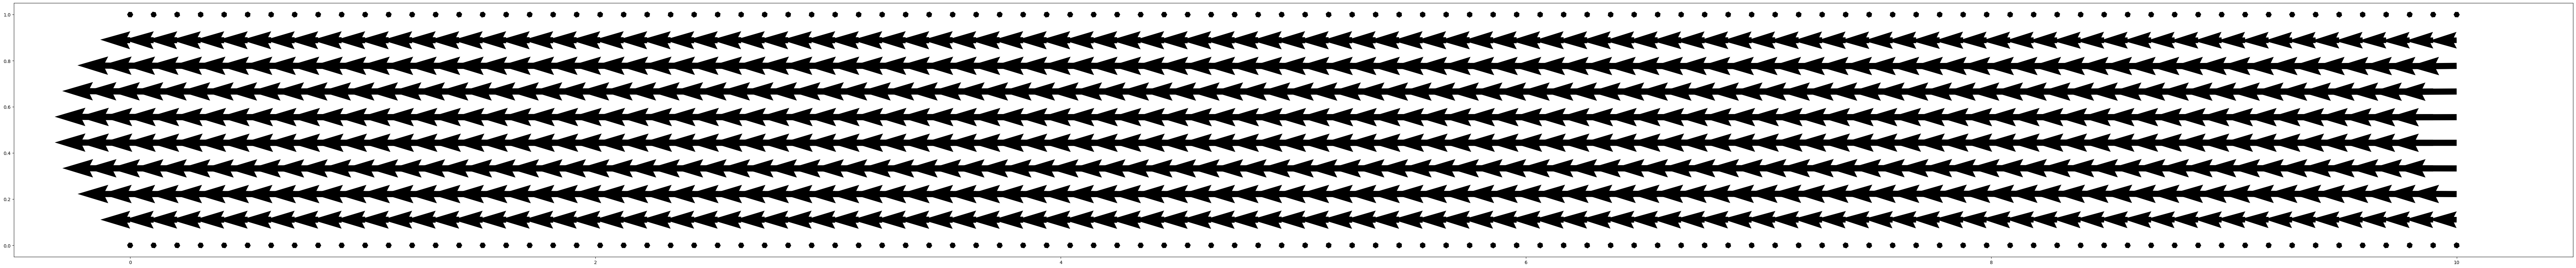

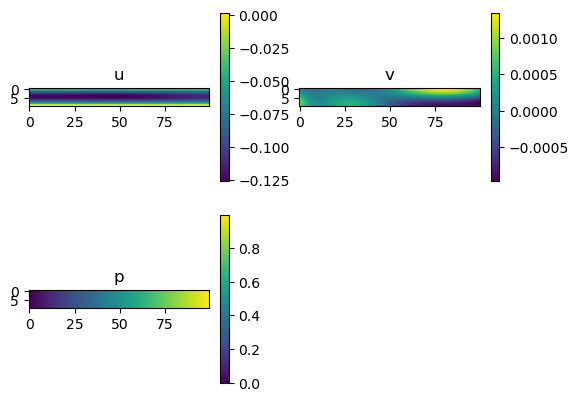

Text(0, 0.5, 'u')

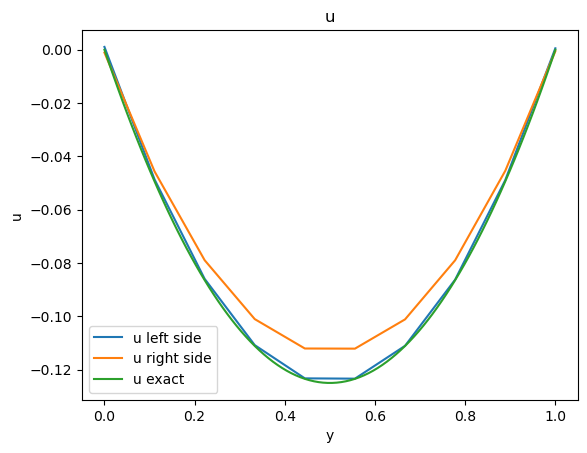

In [16]:

t_bc=np.zeros(1)
x_bc=np.linspace(0,10,100)
y_bc=np.linspace(0,1,10)
t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
t_bcm=np.reshape(t_bcm,(1000,1))
x_bcm=np.reshape(x_bcm,(1000,1))
y_bcm=np.reshape(y_bcm,(1000,1))
pt_t_bc= Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
pt_x_bc= Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
pt_y_bc= Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
psi=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
print(np.shape(psi))
p=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
plt.quiver(x_bcm,y_bcm,u.detach().numpy().reshape((10,100)),v.detach().numpy().reshape((10,100)))
fig=plt.gcf()
fig.set_size_inches(100,10)
plt.show()
plt.subplot(2,2,1)
plt.imshow(u.detach().numpy().reshape((100,10)).T)
plt.title('u')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(v.detach().numpy().reshape((100,10)).T)
plt.title('v')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(p.detach().numpy().reshape((100,10)).T)
plt.title('p')
plt.colorbar()
plt.show()
plt.title('u')
plt.plot(np.linspace(0,1,10),u.detach().numpy().reshape((100,10))[0,:])
plt.plot(np.linspace(0,1,10),u.detach().numpy().reshape((100,10))[-1,:])
plt.plot(np.linspace(0,1,100),(np.linspace(0,1,100)-0.5)**2*0.5-0.125)
plt.legend(['u left side','u right side', 'u exact'])
fig.set_size_inches(20,20)
plt.xlabel('y')
plt.ylabel('u')
#plt.plot(t_test, np.sin(t_test))